# ABSA Case Study
You are a data scientist who has been tasked with developing a versatile ABSA model for extracting aspects, determining aspect polarity, and detecting aspect categories from textual data. The goal is to create a robust model/pipeline ensuring flexibility and accuracy across different contexts.

Aspect-Based Sentiment Analysis (ABSA) is a natural language processing (NLP) technique that involves extracting and analysing sentiment or emotion associated with specific aspects or features of a given target entity, such as a product, service, or topic.  

Data Description:
Your toolkit will include dataset comprising of 3000 customer reviews for a restaurant, all in English, enriched with human-authored annotations. These annotations contain the mentioned aspects of the target entities and the sentiment polarity of each aspect.


Tasks:

•	ABSA Model Development: Create an ABSA model that can extract aspect terms, determine aspect polarity, and identify aspect categories within a given text. Ensure that the model is generic and can be applied to different domains with ease.
•	Results Analysis: Analyze the results generated by the ABSA model. Use matplotlib/ plotly to show the overall as well category wise sentiment distribution. 
•	Actionable insights: Based on the above analysis, derive the conclusions and identify action items for the restaurant to work-upon.
•	Report: Discuss pros and cons of the approach you selected and further improvement which can be done to it given more time.


In particular, the task 1 consists of the following subtasks: 
 
Definition 1: Aspect term extraction 
For the given entity -  restaurant, identify the aspect terms present in the sentence and return a list containing all the distinct aspect terms. An aspect term names a particular aspect of the target entity(Restaurant). 
  
For example, "I liked the service and the staff, but not the food”, “The food was nothing much, but I loved the staff”. Here service, staff and food are aspects.

 Note: Multi-word aspect terms (e.g., “hard disk”) should be treated as single terms (e.g., in “The hard disk is very noisy” the only aspect term is “hard disk”). 
 
Definition 2: Aspect term polarity 
For a given set of aspect terms within a sentence, determine whether the polarity of each aspect term is positive, negative, neutral or conflict (i.e., both positive and negative). 
  
For example: 
 
“I loved their fajitas” → {fajitas: positive} 
“I hated their fajitas, but their salads were great” → {fajitas: negative, salads: positive} 
“The fajitas are their first plate” → {fajitas: neutral} 
“The fajitas were great to taste, but not to see” → {fajitas: conflict} 
 
Definition 3: Aspect category detection 
Decide a predefined set of aspect categories (e.g., price, food, service etc.) for restaurant, identify the aspect categories discussed in a given sentence. Aspect categories are typically coarser than the aspect terms of Subtask 1, and they do not necessarily occur as terms in the given sentence. 
  
For example, given the set of aspect categories {food, service, price, ambience, anecdotes/miscellaneous}: 
“The restaurant was too expensive”  → {aspect -expensive, category - price} 
“The restaurant was expensive, but the menu was great” → { aspect -expensive, category - price, aspect- menu, category - food} 

Definition 4:
Action Items: Areas which can be improved to improve the overall sentiment of the customer.
 


### Execute below command to create Environment
- conda create -n case_study python=3.10 -y 
- List Packages we need to Install
    - torch 
    - torchvision 
    - torchaudio
    - xmltodict
    - pandas
    - nltk
    - matplotlib
    - plotly
    - transformers
    - datasets
    - accelerate
    - evaluate
    - seqeval
    - wandb
    - python-dotenv
    - sentence-transformers
    - sentencepiece




# 1. Data Loading and Preperation

## Creating Essential Folder Structure

In [1]:
import os
def create_directory(dirs: list):
    for dir_path in dirs:
        os.makedirs(dir_path, exist_ok=True)


create_directory(['artifacts/dataset_NER','artifacts/dataset_Category','artifacts/models/ner/final','artifacts/models/ner/epoch','artifacts/dataset','artifacts/models/ner','artifacts/models/category','artifacts/models/sentence_inference'])       

## Loading the XML Data and Pre-processing

In [2]:
import xmltodict

# Open and read the XML file
with open('artifacts/data/Restaurants_Train_v2.xml', 'r') as f:
    xml_content = f.read()

# Convert the XML to a dictionary
xml_dict = xmltodict.parse(xml_content)



#### Let's First see how that Data Looks

In [3]:
print(xml_dict['sentences']['sentence'][0:10])

[{'@id': '3121', 'text': 'But the staff was so horrible to us.', 'aspectTerms': {'aspectTerm': {'@term': 'staff', '@polarity': 'negative', '@from': '8', '@to': '13'}}, 'aspectCategories': {'aspectCategory': {'@category': 'service', '@polarity': 'negative'}}}, {'@id': '2777', 'text': "To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.", 'aspectTerms': {'aspectTerm': {'@term': 'food', '@polarity': 'positive', '@from': '57', '@to': '61'}}, 'aspectCategories': {'aspectCategory': [{'@category': 'food', '@polarity': 'positive'}, {'@category': 'anecdotes/miscellaneous', '@polarity': 'negative'}]}}, {'@id': '1634', 'text': "The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not.", 'aspectTerms': {'aspectTerm': [{'@term': 'food', '@polarity': 'positive', '@from': '4', '@to': '8'}, {'@term': 'kitchen

In [4]:
print(len(xml_dict['sentences']['sentence']))

3041


## First Observation what we can understand from the Data
- It has total 3041 Text and ID's
- Aspect Term: Some place it has multiple Data, some places only single or No Entries.
    - Each Term is coming with label Positive or Negative or Neutral
- Aspect Category: This also in some place Single Data or Multiple Data
    - Similar to Term, it also have each category has label Positive or Negative or Neutral(Not shown here but assuming that is the case)


## First Impression and Understanding

After reading and seeing the dataset, the first impression for the task ABSA Model Development are below:

    - For TERM's the basic impression is NER that would extract words which is Important to Resttaurant Business. 

    - For TERM we also need to Sentence Inferencing between extracted NER and Text to find Polarity i.e. Positive, Negative, Conflict & Neutral. 

    - For Category we need to do Multi-Label sentence Classification for given labels: food, service, price, ambience, anecdotes/miscellaneous.
    
    - For Category also we have to do Sentence Inferencing between Category and Text to find Polarity i.e. Positive, Negative & Neutral. Since in Sample Data viewing we can't find Neutral therefore this is still assumption that there are three labels, will Do EDA to find it

**With above thought we have to do NER and Multi-Label Sentence Classification for training and for Sentence Inferencing since Number of target label are in 4 in number so we have to train Sentence Inferencing too**

**Though we will see if we can find a model with same Target Labels but at the moment it seems, we need to do training for Sentence Inferencing**


**I will try to find if any NER and Multi-Label Sentence Classification models in huggingface hub is available or not which will act as a baseline**  


**Data will have to be splitted between Train and Test as there is not seperate test data was shared with the package**

## We can't use XML Data as given, so we are doing some pre-processing. We would convert data for NER, Multi-Label Sentence Classification and Sentence Inferencing

##### **get_clean_text:** This function is used for Text clean-up. Found some corner case in the text which causing exception so doing pre-prcessing on the text.

In [5]:
import re

def get_clean_text(text):
    # Step 1: Remove single or double quotes surrounding words
    cleaned_string = re.sub(r"(['\"])(\w+)\1", r"\2", text)

    # Step 2: Remove any remaining special characters except apostrophes
    cleaned_string = re.sub(r"[^A-Za-z0-9\s']", '', cleaned_string)
    return cleaned_string



##### **get_ner:** Main motive of this function is to create NER Labels in ***CoNLL*** format. It takes these Input Parameter i.e. Splited Text, Term, From & To positions of the Term in Text and NER Label which would be changed and sent back by updating the NER Label's for the Term. NER Label's are {0: Others, 1: Begin, 2: Intermediate}. The Output Parameter would be Split text & NER Label

In [6]:
def get_ner(split_text,term,from_to,ner_label):
  # split_text = text.split()
  split_term = term.split()

  next=0
  last=0
  word_range=[]
  t_word_range=[]
  index_range=[]

  for k,v in enumerate(split_text):
    word_range.append(v)
    t_word_range.append( get_clean_text(v))
    if v[0] not in ["'",'"']:
      index_range.append(next)
    else:
      index_range.append(next+1)
    # print(v[0])
    if k == 0:
      last = len(v)+1
       
    else:
      last=last+len(v)+1
       
    next = last
  t_index = 0
  try:
    t_index = index_range.index(from_to)
    # print(t_index)
  except:
     
    try:
      t_index = t_word_range.index(split_term[0] )
    except:
      for k,i in enumerate(t_word_range):
        if split_term[0] in i:
          t_index = k
       
  end = t_index + len(split_term)
  
  for k,v in enumerate(range(t_index,end)):
    if k==0:
      ner_label[v]= 1
    else:
      ner_label[v]= 2
  # print(ner_label)
  return word_range, ner_label

##### **get_dataset:** This is the main function which would be called for pre-processing the xml-data. Only Input Parameter is XML_Data and Output Parameter is a list of Dictionary,category_label: {'ambience':0, 'anecdotes/miscellaneous' : 1, 'food':2, 'price':3, 'service':4} and polarity_label: {'conflict':0,'neutral':1,'negative':2,'positive':3}

In [7]:
def get_dataset(xml_dict):
  dataset_aspect = []
  all_lb = set()
  for k,v in enumerate(xml_dict['sentences']['sentence']):
    ds = {}
    category_label = {'ambience':0, 'anecdotes/miscellaneous' : 1, 'food':2, 'price':3, 'service':4}
    # polarity_label_term = {'neutral':0,'negative':1,'positive':2} # 'conflict'
    polarity_label = {'conflict':0,'neutral':1,'negative':2,'positive':3} # 'conflict'
    # if k == 5:
    #   break
    dict_keys = v.keys()
    ds['ID'] = v['@id']
    ds['text'] = v['text']
    ds['NER_INFERENCE'] ={}
    ds['NER_INFERENCE']['term']=[]
    ds['NER_INFERENCE']['polarity']=[]
    ds['NER_INFERENCE']['polarity_label']=[]
    ds['NER_INFERENCE']['from_to']=[]
    ds['NER_INFERENCE']['text']= v['text'].split()
    ds['NER_INFERENCE']['ner_label']= [0]*len(v['text'].split())
    ds['categories']={}
    ds['categories']['category']=[]
    ds['categories']['category_label']=[]
    ds['categories']['polarity']=[]
    ds['categories']['polarity_label']=[]
    # print( v['aspectCategories'])
    # print(dict_keys)
    if 'aspectTerms' in dict_keys:
      if type(v['aspectTerms']['aspectTerm'])==dict:
        # tmp_dict={}
        ds['NER_INFERENCE']['term'].append(v['aspectTerms']['aspectTerm']['@term'])
        ds['NER_INFERENCE']['polarity'].append(v['aspectTerms']['aspectTerm']['@polarity']) #loop
        tmp =[polarity_label[v['aspectTerms']['aspectTerm']['@polarity']]  ]
        ds['NER_INFERENCE']['polarity_label'].extend(tmp ) #loop
        ds['NER_INFERENCE']['from_to'].append((int(v['aspectTerms']['aspectTerm']['@from']),int(v['aspectTerms']['aspectTerm']['@to'])))
        ds['NER_INFERENCE']['text'],ds['NER_INFERENCE']['ner_label']= get_ner(
                                                                                ds['NER_INFERENCE']['text'],
                                                                                v['aspectTerms']['aspectTerm']['@term'],
                                                                                int(v['aspectTerms']['aspectTerm']['@from']),
                                                                                  ds['NER_INFERENCE']['ner_label']
                                                                              )

      else:
        for key,value in enumerate(v['aspectTerms']['aspectTerm']):
          # tmp_dict={}
          ds['NER_INFERENCE']['term'].append(value['@term'])
          ds['NER_INFERENCE']['polarity'].append(value['@polarity']) # loop
          tmp = [polarity_label[value['@polarity']] ]
          ds['NER_INFERENCE']['polarity_label'].extend(tmp) # loop
          ds['NER_INFERENCE']['from_to'].append((int(value['@from']),int(value['@to'])))
          # try:
          ds['NER_INFERENCE']['text'],ds['NER_INFERENCE']['ner_label']= get_ner(
                                                                                ds['NER_INFERENCE']['text'],
                                                                                value['@term'],
                                                                                int(value['@from']),
                                                                                  ds['NER_INFERENCE']['ner_label']
                                                                              )
          # except Exception as e:
          #   print(e)
          #   print('Text: ',ds['text'],' Term: ',value['@term']," from: ",int(value['@from']))
          #   return "error"

    if 'aspectCategories' in dict_keys :
      # print( v['aspectCategories'])
      if type(v['aspectCategories']['aspectCategory'])==dict:
        # print( v['aspectCategories']['aspectCategory']) #['@category'] category_label
        ds['categories']['category'].append(v['aspectCategories']['aspectCategory']['@category']) #loop
        ds['categories']['polarity'].append(v['aspectCategories']['aspectCategory']['@polarity']) #loop
        tmp1 =[category_label[v['aspectCategories']['aspectCategory']['@category']] ]
        tmp2= [polarity_label[v['aspectCategories']['aspectCategory']['@polarity']]  ]
        ds['categories']['category_label'].extend(tmp1) #loop
        ds['categories']['polarity_label'].extend(tmp2) #loop
        all_lb.add(v['aspectCategories']['aspectCategory']['@category'])
      else:
        # print(v['aspectCategories']['aspectCategory'])
        for key,value in enumerate(v['aspectCategories']['aspectCategory']):
          # print(value['@category'])
          ds['categories']['category'].append(value['@category']) #loop
          ds['categories']['polarity'].append(value['@polarity']) # loop
          tmp1 = [category_label[value['@category']]  ]
          tmp2= [polarity_label[value['@polarity']] ]
          ds['categories']['category_label'].extend(tmp1) #loop
          ds['categories']['polarity_label'].extend(tmp2) # loop
          all_lb.add(value['@category'])
      # pass
    dataset_aspect.append(ds)
  return dataset_aspect,category_label , polarity_label

In [8]:
dataset_aspect,category_label , polarity_label= get_dataset(xml_dict)

##### List of Category and polarity label

In [9]:
category_label , polarity_label

({'ambience': 0,
  'anecdotes/miscellaneous': 1,
  'food': 2,
  'price': 3,
  'service': 4},
 {'conflict': 0, 'neutral': 1, 'negative': 2, 'positive': 3})

##### After Pre-processing just vewing the data

In [10]:
dataset_aspect[:1]

[{'ID': '3121',
  'text': 'But the staff was so horrible to us.',
  'NER_INFERENCE': {'term': ['staff'],
   'polarity': ['negative'],
   'polarity_label': [2],
   'from_to': [(8, 13)],
   'text': ['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us.'],
   'ner_label': [0, 0, 1, 0, 0, 0, 0, 0]},
  'categories': {'category': ['service'],
   'category_label': [4],
   'polarity': ['negative'],
   'polarity_label': [2]}}]

In [11]:
import json

with open("artifacts/data/process_data.jsonl", "w") as final:
    json.dump(dataset_aspect, final)

## Now Loading Dataset in Huggingface Datasets

In [12]:
from datasets import load_dataset
dataset = load_dataset("json", data_files="artifacts/data/process_data.jsonl")
dataset

/Users/nabarunbarua/miniconda3/envs/case_study/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 3041 examples [00:00, 93615.85 examples/s]


DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'NER_INFERENCE', 'categories'],
        num_rows: 3041
    })
})

##### Doing Train Test split and saving the dataset

In [13]:
dataset = dataset['train'].train_test_split(test_size=0.1,seed=199)

tmp = dataset['test'].train_test_split(test_size=0.3,seed=199)

dataset['test'] = tmp['train']
dataset['dev'] = tmp['test']

dataset.save_to_disk('artifacts/dataset')

Saving the dataset (1/1 shards): 100%|██████████| 92/92 [00:00<00:00, 17788.86 examples/s]


##### Incase want to load from Location

In [14]:
# from datasets import load_from_disk
# ds = load_from_disk('artifacts/dataset')
# ds

### We are creating a seperate Dataset for Category/NER/EDA from main dataset so that for Training & EDA we can use it skip NER Pre-processing

In [15]:
flat_dataset = dataset.flatten()
flat_dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'NER_INFERENCE.from_to', 'NER_INFERENCE.ner_label', 'NER_INFERENCE.polarity', 'NER_INFERENCE.polarity_label', 'NER_INFERENCE.term', 'NER_INFERENCE.text', 'categories.category', 'categories.category_label', 'categories.polarity', 'categories.polarity_label'],
        num_rows: 2736
    })
    test: Dataset({
        features: ['ID', 'text', 'NER_INFERENCE.from_to', 'NER_INFERENCE.ner_label', 'NER_INFERENCE.polarity', 'NER_INFERENCE.polarity_label', 'NER_INFERENCE.term', 'NER_INFERENCE.text', 'categories.category', 'categories.category_label', 'categories.polarity', 'categories.polarity_label'],
        num_rows: 213
    })
    dev: Dataset({
        features: ['ID', 'text', 'NER_INFERENCE.from_to', 'NER_INFERENCE.ner_label', 'NER_INFERENCE.polarity', 'NER_INFERENCE.polarity_label', 'NER_INFERENCE.term', 'NER_INFERENCE.text', 'categories.category', 'categories.category_label', 'categories.polarity', 'categories.polarity_

In [16]:
flat_dataset['train'][0]

{'ID': '2927',
 'text': 'The decor in this place is very diner-ish and the kind of place you expect in the East Village - not romantic, just simple, small and sparse.',
 'NER_INFERENCE.from_to': [[4, 9], [58, 63]],
 'NER_INFERENCE.ner_label': [0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'NER_INFERENCE.polarity': ['positive', 'positive'],
 'NER_INFERENCE.polarity_label': [3, 3],
 'NER_INFERENCE.term': ['decor', 'place'],
 'NER_INFERENCE.text': ['The',
  'decor',
  'in',
  'this',
  'place',
  'is',
  'very',
  'diner-ish',
  'and',
  'the',
  'kind',
  'of',
  'place',
  'you',
  'expect',
  'in',
  'the',
  'East',
  'Village',
  '-',
  'not',
  'romantic,',
  'just',
  'simple,',
  'small',
  'and',
  'sparse.'],
 'categories.category': ['ambience'],
 'categories.category_label': [0],
 'categories.polarity': ['positive'],
 'categories.polarity_label': [3]}

##### NER-EDA Dataset Preperation

polarity_label: {'conflict':0,'neutral':1,'negative':2,'positive':3}

In [17]:
NER_train = []
NER_test=[]
NER_dev = []
for data in flat_dataset['train']:
    NER_dict={}
    NER_dict['ID'] = data['ID']
    NER_dict['text']= data['text']
    NER_dict['split_text'] = data['NER_INFERENCE.text']
    NER_dict['ner_label'] = data['NER_INFERENCE.ner_label']
    NER_dict['term'] = data['NER_INFERENCE.term']
    NER_dict['polarity'] = data['NER_INFERENCE.polarity_label']
    NER_train.append(NER_dict)
    # break

for data in flat_dataset['test']:
    NER_dict={}
    NER_dict['ID'] = data['ID']
    NER_dict['text']= data['text']
    NER_dict['split_text'] = data['NER_INFERENCE.text']
    NER_dict['ner_label'] = data['NER_INFERENCE.ner_label']
    NER_dict['term'] = data['NER_INFERENCE.term']
    NER_dict['polarity'] = data['NER_INFERENCE.polarity_label']
    NER_test.append(NER_dict)
    # break

for data in flat_dataset['dev']:
    NER_dict={}
    NER_dict['ID'] = data['ID']
    NER_dict['text']= data['text']
    NER_dict['split_text'] = data['NER_INFERENCE.text']
    NER_dict['ner_label'] = data['NER_INFERENCE.ner_label']
    NER_dict['term'] = data['NER_INFERENCE.term']
    NER_dict['polarity'] = data['NER_INFERENCE.polarity_label']
    NER_dev.append(NER_dict)
    # break

len(NER_train), len(NER_test), len(NER_dev)

(2736, 213, 92)

In [18]:
from datasets import Dataset

train_dataset = Dataset.from_list(NER_train)
test_dataset = Dataset.from_list(NER_test)
dev_dataset = Dataset.from_list(NER_dev)

In [19]:
from datasets import DatasetDict

NER_DATASET = DatasetDict({'train':train_dataset,'test':test_dataset,'dev':dev_dataset})
NER_DATASET

DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'split_text', 'ner_label', 'term', 'polarity'],
        num_rows: 2736
    })
    test: Dataset({
        features: ['ID', 'text', 'split_text', 'ner_label', 'term', 'polarity'],
        num_rows: 213
    })
    dev: Dataset({
        features: ['ID', 'text', 'split_text', 'ner_label', 'term', 'polarity'],
        num_rows: 92
    })
})

In [20]:
NER_DATASET.save_to_disk('artifacts/dataset_NER')

Saving the dataset (1/1 shards): 100%|██████████| 92/92 [00:00<00:00, 24461.23 examples/s]


In [21]:
# from datasets import load_from_disk

# NER_DATASET =  load_from_disk('artifacts/dataset_NER')

In [22]:
NER_DATASET['train'].set_format(type='pandas')
df = NER_DATASET['train'][:]
df.head()

,ID,text,split_text,ner_label,term,polarity
0,2927,The decor in this place is very diner-ish and ...,"[The, decor, in, this, place, is, very, diner-...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[decor, place]","[3, 3]"
1,2028,My friends and I experienced amazing cheese an...,"[My, friends, and, I, experienced, amazing, ch...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...","[cheese, menu]","[3, 3]"
2,2715,"The steak is good, the fish is good and the su...","[The, steak, is, good,, the, fish, is, good, a...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]","[steak, fish, sushi]","[3, 3, 3]"
3,1580,The staff was the friendliest that have seen i...,"[The, staff, was, the, friendliest, that, have...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[staff],[3]
4,958,"I choose to go with one of the special, the br...","[I, choose, to, go, with, one, of, the, specia...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2, 2, 2, ...","[braised lamb shank in red wine, special]","[3, 3]"


In [23]:
NER_DATASET['train'].reset_format()

In [24]:
NER_DATASET['train']

Dataset({
    features: ['ID', 'text', 'split_text', 'ner_label', 'term', 'polarity'],
    num_rows: 2736
})

##### Category-EDA Dataset Preperation

category_label: {'ambience':0, 'anecdotes/miscellaneous' : 1, 'food':2, 'price':3, 'service':4} 


polarity_label: {'conflict':0,'neutral':1,'negative':2,'positive':3}

In [25]:
category_train = []
category_test=[]
category_dev = []
for data in flat_dataset['train']:
    category_dict={}
    category_dict['ID'] = data['ID']
    category_dict['text']= data['text']
    category_dict['category_label'] = data['categories.category_label']
    category_dict['polarity_label'] = data['categories.polarity_label']
     
    category_train.append(category_dict)
    # break

for data in flat_dataset['test']:
    category_dict={}
    category_dict['ID'] = data['ID']
    category_dict['text']= data['text']
    category_dict['category_label'] = data['categories.category_label']
    category_dict['polarity_label'] = data['categories.polarity_label']
    category_test.append(category_dict)
    # break

for data in flat_dataset['dev']:
    category_dict={}
    category_dict['ID'] = data['ID']
    category_dict['text']= data['text']
    category_dict['category_label'] = data['categories.category_label']
    category_dict['polarity_label'] = data['categories.polarity_label']
    category_dev.append(category_dict)
    # break

len(category_train), len(category_test), len(category_dev)

(2736, 213, 92)

In [26]:
from datasets import Dataset

train_dataset = Dataset.from_list(category_train)
test_dataset = Dataset.from_list(category_test)
dev_dataset = Dataset.from_list(category_dev)

In [27]:
from datasets import DatasetDict

CATEGORY_DATASET = DatasetDict({'train':train_dataset,'test':test_dataset,'dev':dev_dataset })
CATEGORY_DATASET

DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'category_label', 'polarity_label'],
        num_rows: 2736
    })
    test: Dataset({
        features: ['ID', 'text', 'category_label', 'polarity_label'],
        num_rows: 213
    })
    dev: Dataset({
        features: ['ID', 'text', 'category_label', 'polarity_label'],
        num_rows: 92
    })
})

In [28]:
CATEGORY_DATASET.save_to_disk('artifacts/dataset_Category')

Saving the dataset (1/1 shards): 100%|██████████| 92/92 [00:00<00:00, 26212.62 examples/s]


In [29]:
# from datasets import load_from_disk

# CATEGORY_DATASET =  load_from_disk('artifacts/dataset_Category')

In [30]:
CATEGORY_DATASET['train'].set_format(type='pandas')
df = CATEGORY_DATASET['train'][:]
df.head()

,ID,text,category_label,polarity_label
0,2927,The decor in this place is very diner-ish and ...,[0],[3]
1,2028,My friends and I experienced amazing cheese an...,"[2, 1]","[3, 3]"
2,2715,"The steak is good, the fish is good and the su...",[2],[3]
3,1580,The staff was the friendliest that have seen i...,[4],[3]
4,958,"I choose to go with one of the special, the br...",[2],[3]


In [31]:
CATEGORY_DATASET['train'].reset_format()

In [32]:
CATEGORY_DATASET['train']

Dataset({
    features: ['ID', 'text', 'category_label', 'polarity_label'],
    num_rows: 2736
})

# 2. EDA

## All Dataset Preparation done. Now let's do EDA.


#### Let's check for Text Length

We can see Maximum Number of Words would be 69 and Minimum would be 1 i.e. Train set

In [33]:
import matplotlib.pyplot as plt

def text_length(dataset,label):
    max_length = 0
    min_length = 99999999
    
    ds =  dataset[label]
    ds.set_format(type='pandas')
    df = ds[:]
    # min_length=min(min_length,len(df['split_text'][0]))
    for data in df['split_text']:
        max_length = max(max_length,len(data))
        min_length=min(min_length,len(data))
    

    print("Max Length:",max_length, "Min Length:",min_length)

     

    # Count tokens (words) in each text
    token_counts = [len(data) for data in df['split_text']]

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(token_counts, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency (Number of Sentences)')
    plt.title('Distribution of Tokens per Sentence')

    # Show the plot
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.show()

    

    

Max Length: 69 Min Length: 1


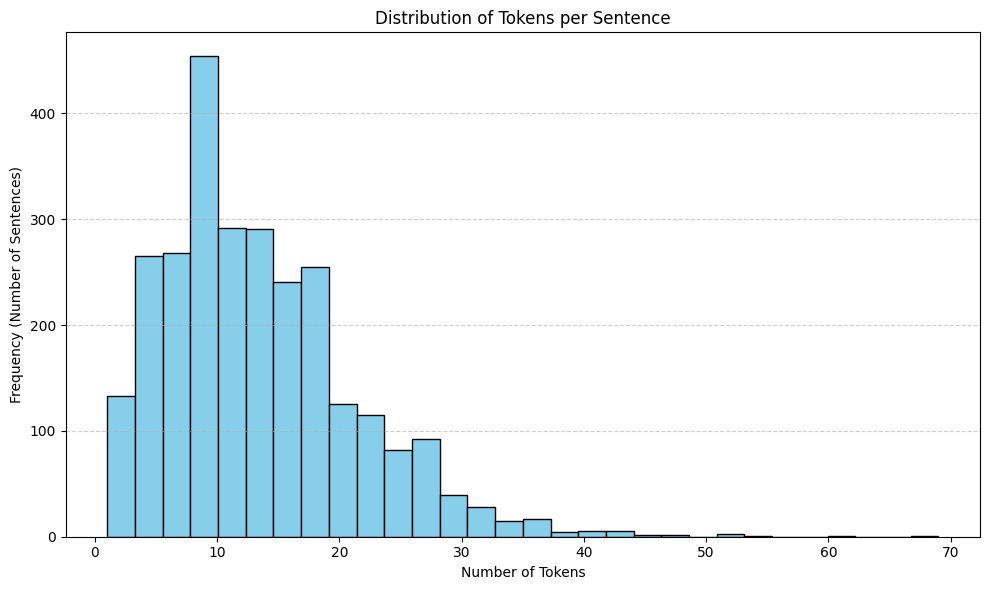

In [34]:
text_length(NER_DATASET,"train")

Max Length: 43 Min Length: 1


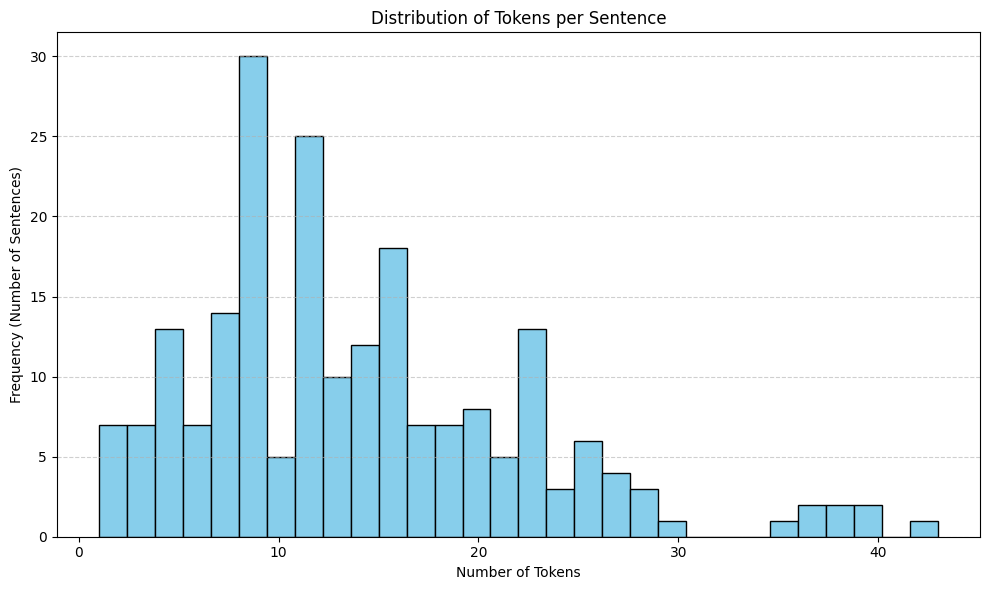

In [35]:
text_length(NER_DATASET,"test")

Max Length: 42 Min Length: 3


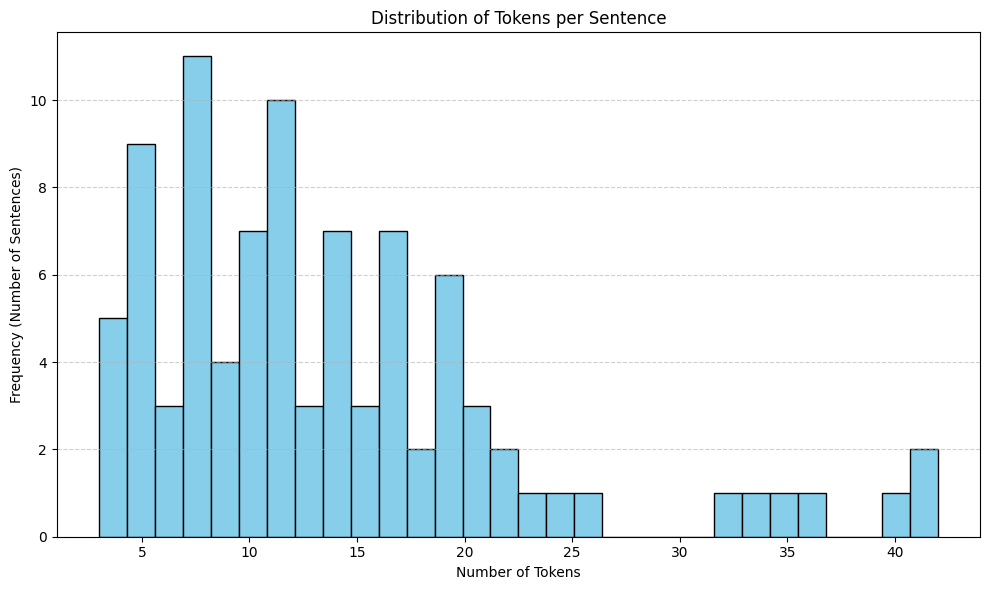

In [36]:
text_length(NER_DATASET,"dev")

#### Let's check Polarity count for TERM

In [37]:
import matplotlib.pyplot as plt


def polarity_NER(dataset,label):
    polarity_label_id= {0:'conflict',1:'neutral',2:'negative',3:'positive'}
    ds = dataset[label]
    conflict=0
    neutral=0
    negative=0
    positive=0

    ds.set_format(type='pandas')
    df = ds[:]
    for term,polarity in zip(df['term'],df['polarity']):
        # print(term,polarity)
        for i in polarity:
            if polarity_label_id[i] == 'conflict':
                conflict += 1
            elif polarity_label_id[i] == 'neutral':
                neutral +=1
            elif polarity_label_id[i] == 'negative':
                negative +=1
            elif polarity_label_id[i] == 'positive':
                positive +=1

    print("Conflict: ",conflict," Neutral: ",neutral," Negative: ",negative," Positive: ",positive)
     
    metrics = {
        'Conflict': conflict, 
        'Neutral': neutral, 
        'Negative': negative, 
        'Positive': positive, 
        
    }

    # Extracting metric names and values
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.barh(metric_names, metric_values, color='skyblue')
    plt.xlabel('Polarity')
    plt.title('Count')
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width()}',
                 va='center', ha='left', color='black', fontweight='bold')

    # Display the chart
    plt.tight_layout()
    plt.show()

        
    

In [38]:
# from sentence_transformers import CrossEncoder
# model = CrossEncoder("cross-encoder/nli-deberta-v3-base")

# scores = model.predict([
#     ("The rest of the menu is limited by everything is good eats.", "While the menu isn't especially groundbreaking, everything I've tried so far has been well-executed and tasty."),
#     ("menu", "menu"),
# ])

# # Convert scores to labels
# label_mapping = ["contradiction", "entailment", "neutral"]
# labels = [label_mapping[score_max] for score_max in scores.argmax(axis=1)]
# labels

##### We can see that Conflict has 83 count only and Neutral 561 & Conflict count is very low

Conflict:  83  Neutral:  561  Negative:  687  Positive:  1966


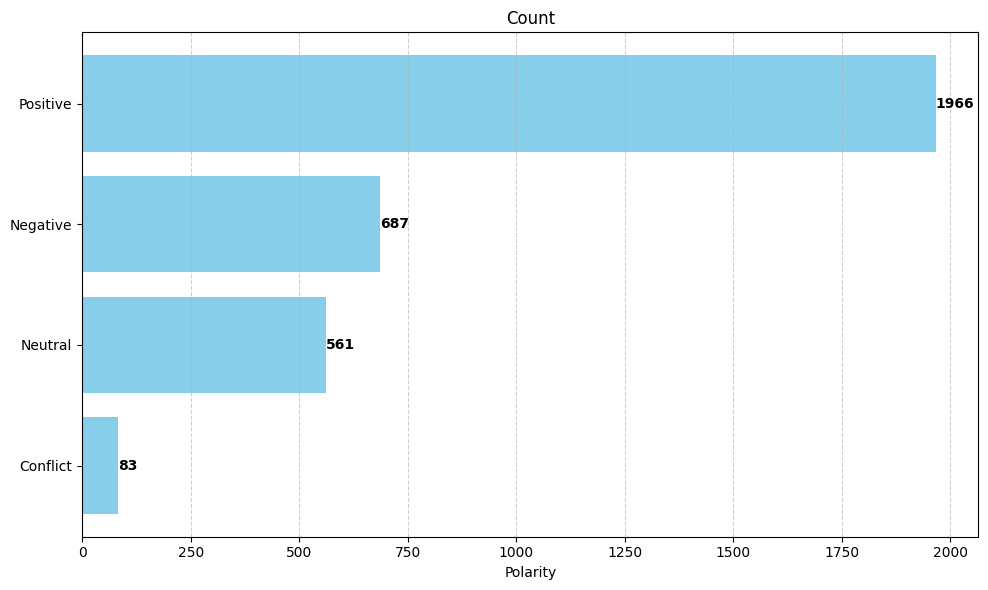

In [39]:
polarity_NER(NER_DATASET,'train')

##### Same we can see that Conflict has 4 count only and Neutral 53 

Conflict:  4  Neutral:  53  Negative:  69  Positive:  132


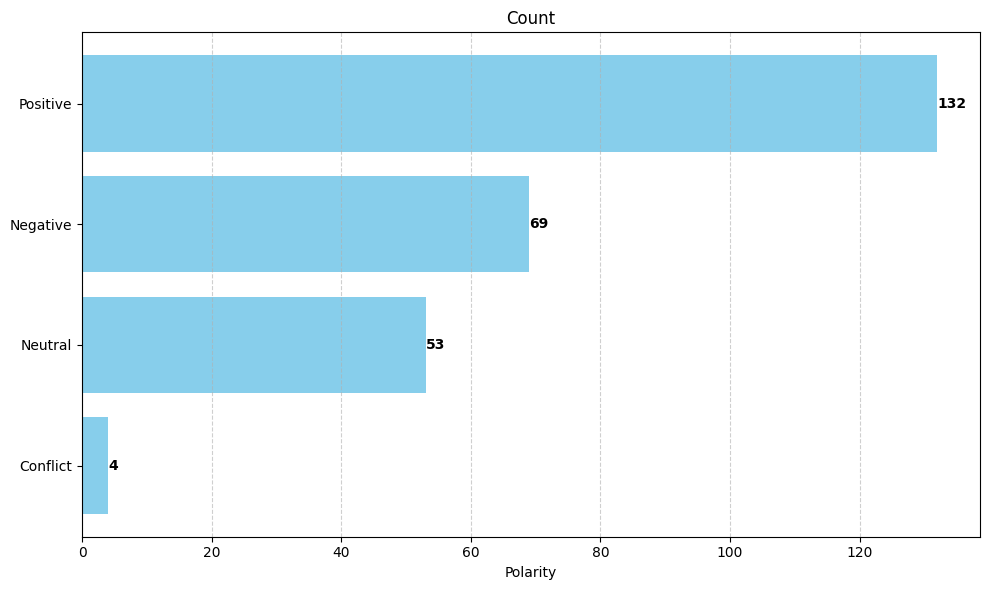

In [40]:
polarity_NER(NER_DATASET,'test')

##### Similar trend here also

Conflict:  4  Neutral:  19  Negative:  49  Positive:  66


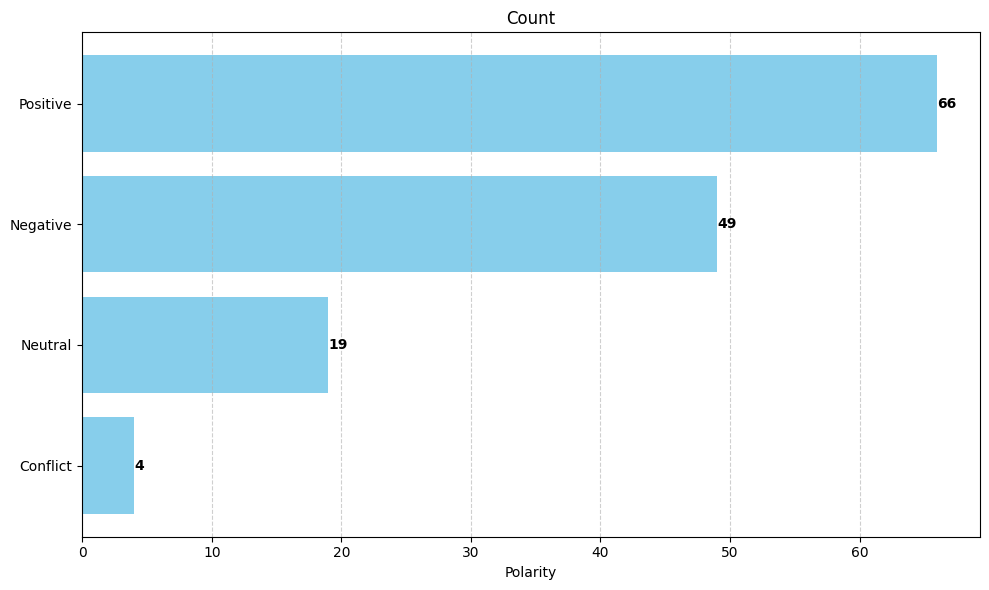

In [41]:
polarity_NER(NER_DATASET,'dev')

In [42]:
Process_NER_Dataset = NER_DATASET 

##### Let see some conflect Data to see and check it's relevance

In [43]:
def polarity_NER_(dataset,label):
    polarity_label_id= {0:'conflict',1:'neutral',2:'negative',3:'positive'}
    ds = dataset[label]
    conflict=0
    neutral=0
    negative=0
    positive=0

    ds.set_format(type='pandas')
    df = ds[:]
    for term,polarity,text in zip(df['term'],df['polarity'],df['text']):
        # print(term,polarity)
        for i,j in zip(polarity,term):
            if polarity_label_id[i] == 'conflict':
                conflict += 1
                print('Text:',text,' Term:',j,' Polarity:',polarity_label_id[i])
            elif polarity_label_id[i] == 'neutral':
                neutral +=1
            elif polarity_label_id[i] == 'negative':
                negative +=1
            elif polarity_label_id[i] == 'positive':
                positive +=1

        
    print("Conflict: ",conflict," Neutral: ",neutral," Negative: ",negative," Positive: ",positive)

polarity_NER_(Process_NER_Dataset,'test')
Process_NER_Dataset.reset_format()

Text: My biggest complaint was the un-tasty food although presented well.  Term: food  Polarity: conflict
Text: The rest of the menu is limited by everything is good eats.  Term: menu  Polarity: conflict
Text: Perhaps this food is considered extreme to an Upper East Side resident, but for the rest of us who've actually eaten ethnic food, this is simply dull.  Term: food  Polarity: conflict
Text: The food was pretty good, but a little flavorless and the portions very small, including dessert.  Term: food  Polarity: conflict
Conflict:  4  Neutral:  53  Negative:  69  Positive:  132


In [44]:
# def polarity_funct(examples):
#     polarity = [
#                     [ 
#                     #    2 if j==0 else j for j in i  
#                         j for j in i 
#                     ] for i in examples['polarity']
#                 ]
#     examples['polarity']= polarity
#     return examples
    
# Process_NER_Dataset = NER_DATASET.map(polarity_funct, batched=True)
# Process_NER_Dataset

#### Conflict signify that the Term and Sentence are in conflecting state

#### Let's check Polarity count for Category


In [45]:
import matplotlib.pyplot as plt
def polarity_Category(dataset,label):
    polarity_label_id= {0:'conflict',1:'neutral',2:'negative',3:'positive'}
    ds = dataset[label]
    conflict=0
    neutral=0
    negative=0
    positive=0

    ds.set_format(type='pandas')
    df = ds[:]
    for category,polarity in zip(df['category_label'],df['polarity_label']):
        # print(term,polarity)
        for i in polarity:
            if polarity_label_id[i] == 'conflict':
                conflict += 1
            elif polarity_label_id[i] == 'neutral':
                neutral +=1
            elif polarity_label_id[i] == 'negative':
                negative +=1
            elif polarity_label_id[i] == 'positive':
                positive +=1

        
    print("Conflict: ",conflict," Neutral: ",neutral," Negative: ",negative," Positive: ",positive)
    metrics = {
        'Conflict': conflict, 
        'Neutral': neutral, 
        'Negative': negative, 
        'Positive': positive, 
        
    }

    # Extracting metric names and values
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    bars= plt.barh(metric_names, metric_values, color='skyblue')
    plt.xlabel('Polarity')
    plt.title('Count')
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width()}',
                 va='center', ha='left', color='black', fontweight='bold')
    # Display the chart
    plt.tight_layout()
    plt.show()

##### Similar to NER, here in Category Trend is same for both train, test & Unseen set

Conflict:  167  Neutral:  450  Negative:  746  Positive:  1985


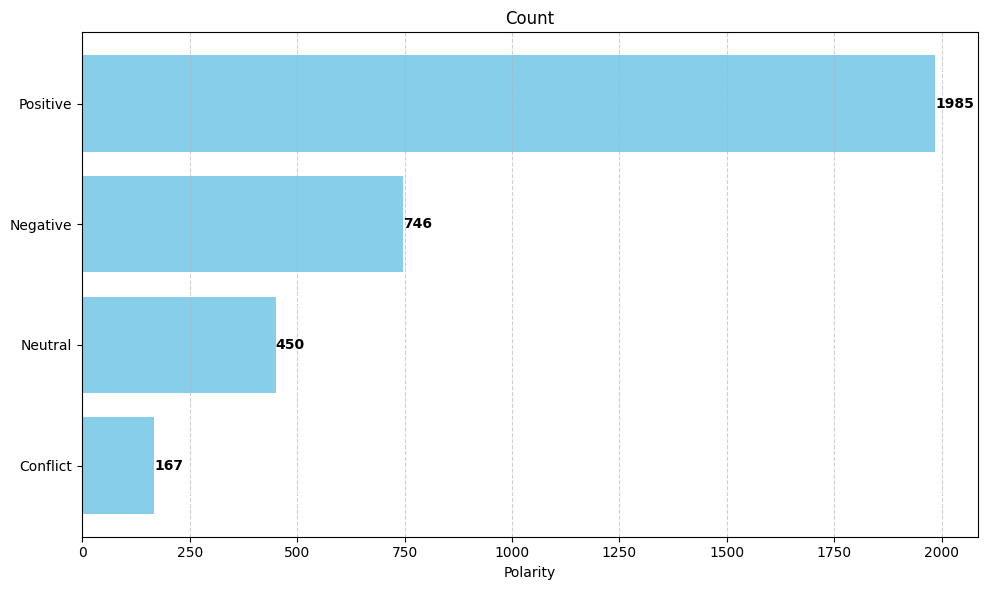

In [46]:
polarity_Category(CATEGORY_DATASET,'train')

Conflict:  17  Neutral:  41  Negative:  65  Positive:  127


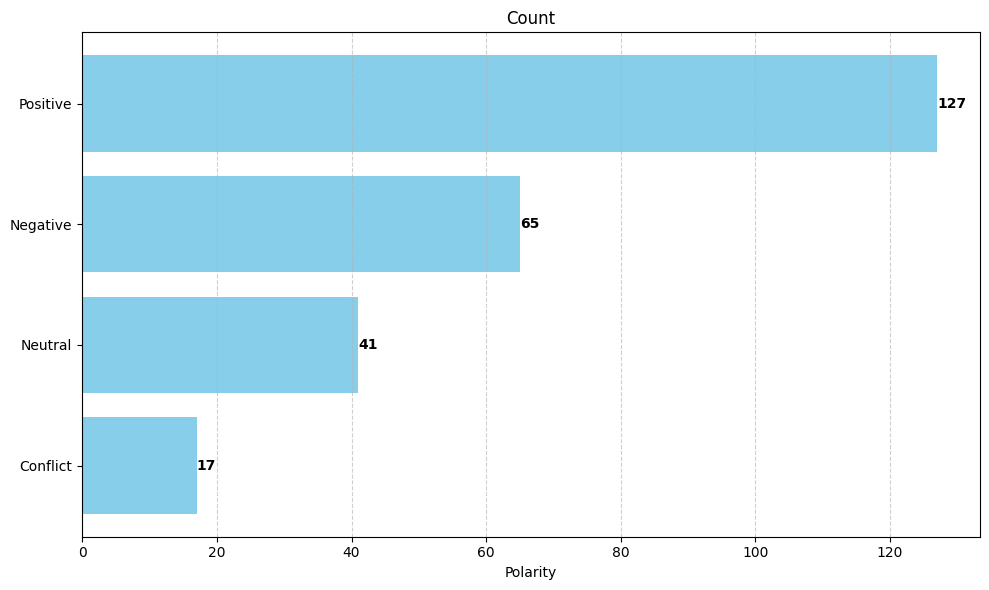

In [47]:
polarity_Category(CATEGORY_DATASET,'test')

Conflict:  11  Neutral:  9  Negative:  28  Positive:  67


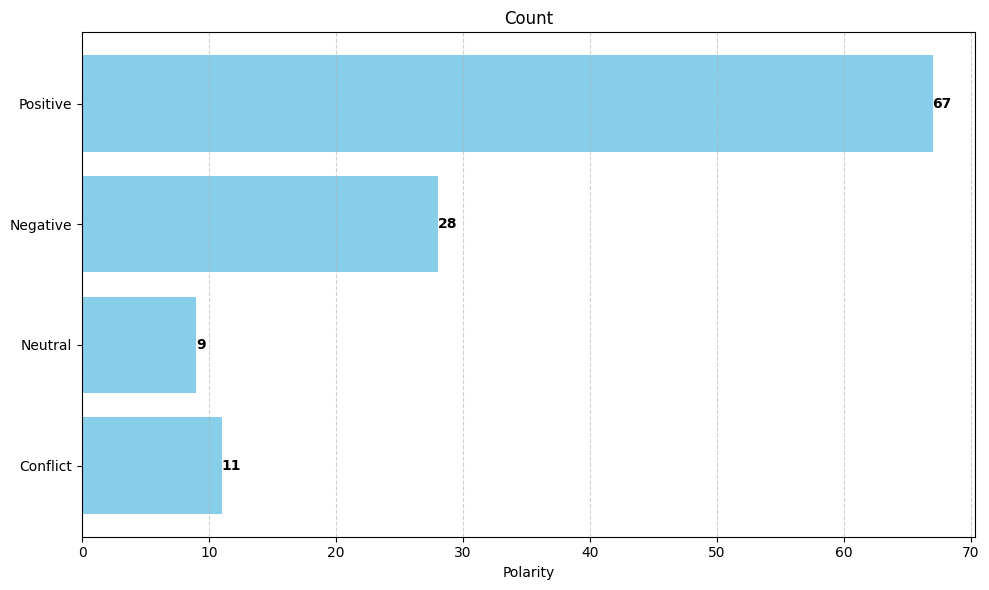

In [48]:
polarity_Category(CATEGORY_DATASET,'dev')

##### Now let's see if we take both category and polarity togather then how it looks

In [49]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
def polarity_Category_wise(dataset,label):
    polarity_label_id= {0:'conflict',1:'neutral',2:'negative',3:'positive'}
    category_label_id= {0:'ambience',1: 'anecdotes/miscellaneous' , 2:'food', 3:'price', 4:'service'}  
    ds = dataset[label]
    # conflict=0
    # neutral=0
    # negative=0
    # positive=0

    calculate_category = {
                            'ambience': {'conflict':0,'neutral':0,'negative':0,'positive':0,'total_count':0},
                            'anecdotes/miscellaneous':{'conflict':0,'neutral':0,'negative':0,'positive':0,'total_count':0},
                            'food': {'conflict':0,'neutral':0,'negative':0,'positive':0,'total_count':0},
                            'price': {'conflict':0,'neutral':0,'negative':0,'positive':0,'total_count':0},
                            'service': {'conflict':0,'neutral':0,'negative':0,'positive':0,'total_count':0},
                          }

    ds.set_format(type='pandas')
    df = ds[:]
    for category,polarity in zip(df['category_label'],df['polarity_label']):
        for c,p in zip(category,polarity):
            if category_label_id[c]== 'ambience':
                calculate_category['ambience']['total_count'] +=1
                if polarity_label_id[p] == 'conflict':
                    calculate_category['ambience']['conflict'] += 1
                elif polarity_label_id[p] == 'neutral':
                    calculate_category['ambience']['neutral'] +=1
                elif polarity_label_id[p] == 'negative':
                    calculate_category['ambience']['negative'] +=1
                elif polarity_label_id[p] == 'positive':
                    calculate_category['ambience']['positive'] +=1

            elif category_label_id[c]== 'anecdotes/miscellaneous':
                calculate_category['anecdotes/miscellaneous']['total_count'] +=1
                if polarity_label_id[p] == 'conflict':
                    calculate_category['anecdotes/miscellaneous']['conflict'] += 1
                elif polarity_label_id[p] == 'neutral':
                    calculate_category['anecdotes/miscellaneous']['neutral'] +=1
                elif polarity_label_id[p] == 'negative':
                    calculate_category['anecdotes/miscellaneous']['negative'] +=1
                elif polarity_label_id[p] == 'positive':
                    calculate_category['anecdotes/miscellaneous']['positive'] +=1

            elif category_label_id[c]== 'food':
                calculate_category['food']['total_count'] +=1
                if polarity_label_id[p] == 'conflict':
                    calculate_category['food']['conflict'] += 1
                elif polarity_label_id[p] == 'neutral':
                    calculate_category['food']['neutral'] +=1
                elif polarity_label_id[p] == 'negative':
                    calculate_category['food']['negative'] +=1
                elif polarity_label_id[p] == 'positive':
                    calculate_category['food']['positive'] +=1

            elif category_label_id[c]== 'price':
                calculate_category['price']['total_count'] +=1
                if polarity_label_id[p] == 'conflict':
                    calculate_category['price']['conflict'] += 1
                elif polarity_label_id[p] == 'neutral':
                    calculate_category['price']['neutral'] +=1
                elif polarity_label_id[p] == 'negative':
                    calculate_category['price']['negative'] +=1
                elif polarity_label_id[p] == 'positive':
                    calculate_category['price']['positive'] +=1

            elif category_label_id[c]== 'service':
                calculate_category['service']['total_count'] +=1
                if polarity_label_id[p] == 'conflict':
                    calculate_category['service']['conflict'] += 1
                elif polarity_label_id[p] == 'neutral':
                    calculate_category['service']['neutral'] +=1
                elif polarity_label_id[p] == 'negative':
                    calculate_category['service']['negative'] +=1
                elif polarity_label_id[p] == 'positive':
                    calculate_category['service']['positive'] +=1

    # Aspect names and sentiments
    category_ = list(calculate_category.keys())
    conflict = [calculate_category[cat]['conflict'] for cat in category_]
    negative = [calculate_category[cat]['negative'] for cat in category_]
    neutral = [calculate_category[cat]['neutral'] for cat in category_]
    positive = [calculate_category[cat]['positive'] for cat in category_]    
    
    x = np.arange(len(category_ ))

    width = 0.6

    # Plotting the stacked bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x, conflict, width, label='Conflict', color='lightcoral')
    ax.bar(x, negative, width, bottom=conflict, label='Negative', color='orange')
    ax.bar(x, neutral, width, bottom=np.array(conflict) + np.array(negative), label='Neutral', color='lightblue')
    ax.bar(x, positive, width, bottom=np.array(conflict) + np.array(negative) + np.array(neutral), label='Positive', color='lightgreen')

    for i in range(len(x)):
        # total = conflict[i] + negative[i] + neutral[i] + positive[i]
        # ax.text(i, total, str(total), ha='center', va='bottom', fontweight='bold')
         # Conflict
        ax.text(i, conflict[i]/2, str(conflict[i]), ha='center', va='center', color='black', fontweight='bold')

        # Negative
        ax.text(i, conflict[i] + negative[i]/2, str(negative[i]), ha='center', va='center', color='black', fontweight='bold')

        # Neutral
        ax.text(i, conflict[i] + negative[i] + neutral[i]/2, str(neutral[i]), ha='center', va='center', color='black', fontweight='bold')

        # Positive
        ax.text(i, conflict[i] + negative[i] + neutral[i] + positive[i]/2, str(positive[i]), ha='center', va='center', color='black', fontweight='bold')
    # Adding labels and title
    ax.set_xlabel('Category')
    ax.set_ylabel('Count of Reviews')
    ax.set_title('Sentiment Distribution Across Category')
    ax.set_xticks(x)
    ax.set_xticklabels(category_, rotation=45, ha='right')
    ax.legend()

    # Show plot
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.show()
    # pprint(calculate_category)

##### Similar as above Conflict still in less in number compare to others. 

##### Another observation is price and ambience category has less count compare to others.

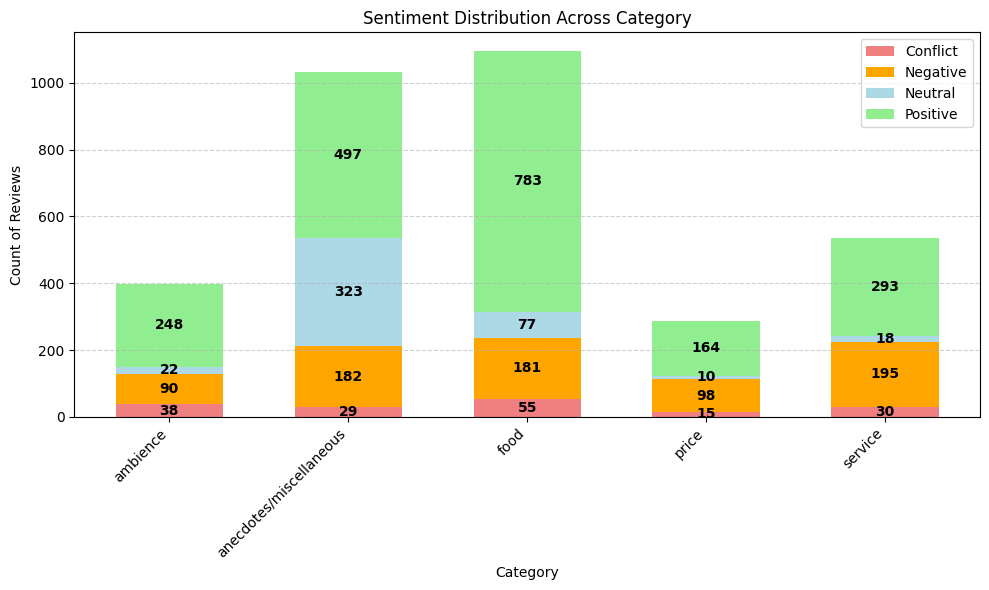

In [50]:
polarity_Category_wise(CATEGORY_DATASET,'train')

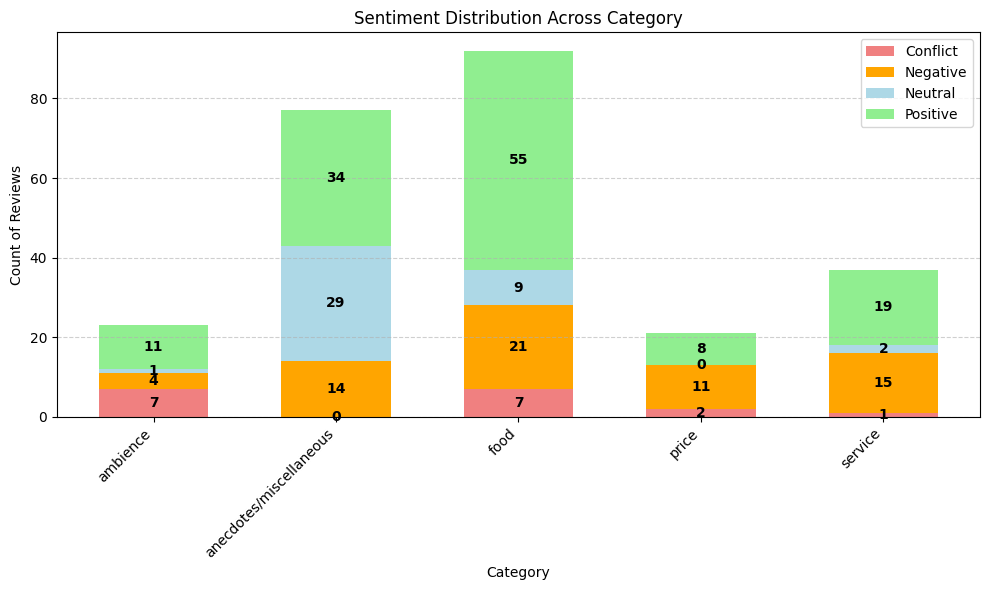

In [51]:
polarity_Category_wise(CATEGORY_DATASET,'test')

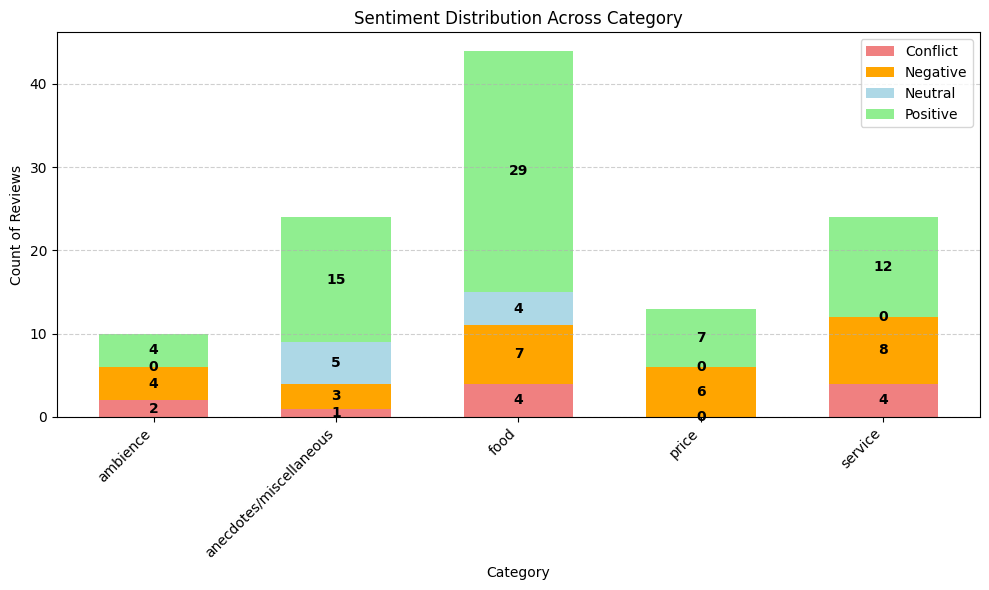

In [52]:
polarity_Category_wise(CATEGORY_DATASET,'dev')

In [53]:
Process_Category_Dataset = CATEGORY_DATASET

##### Now we can see for train, test and Unseen dataset's count



Conflict:  167  Neutral:  450  Negative:  746  Positive:  1985


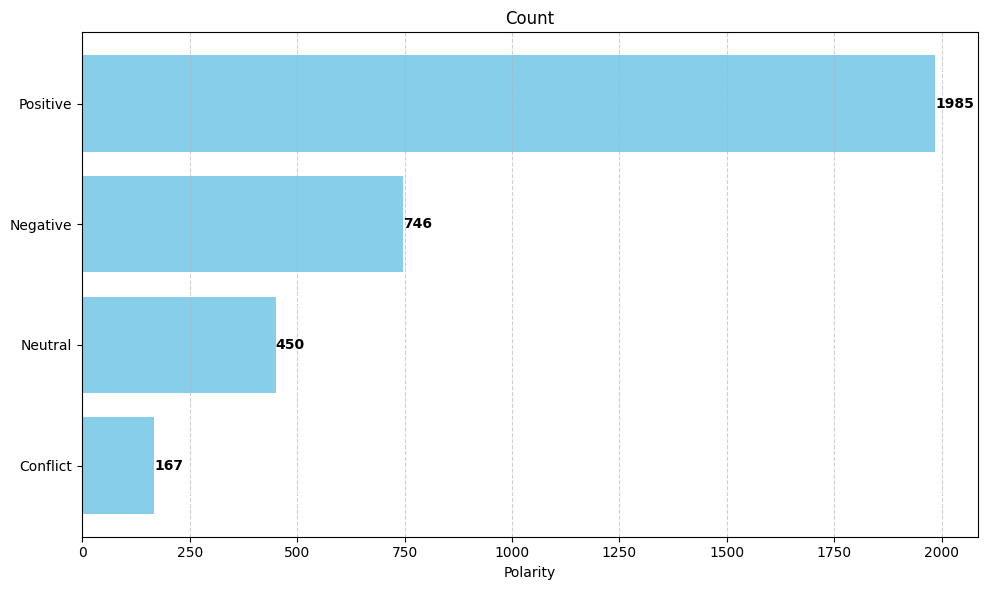

In [54]:
polarity_Category(Process_Category_Dataset,'train')

Conflict:  17  Neutral:  41  Negative:  65  Positive:  127


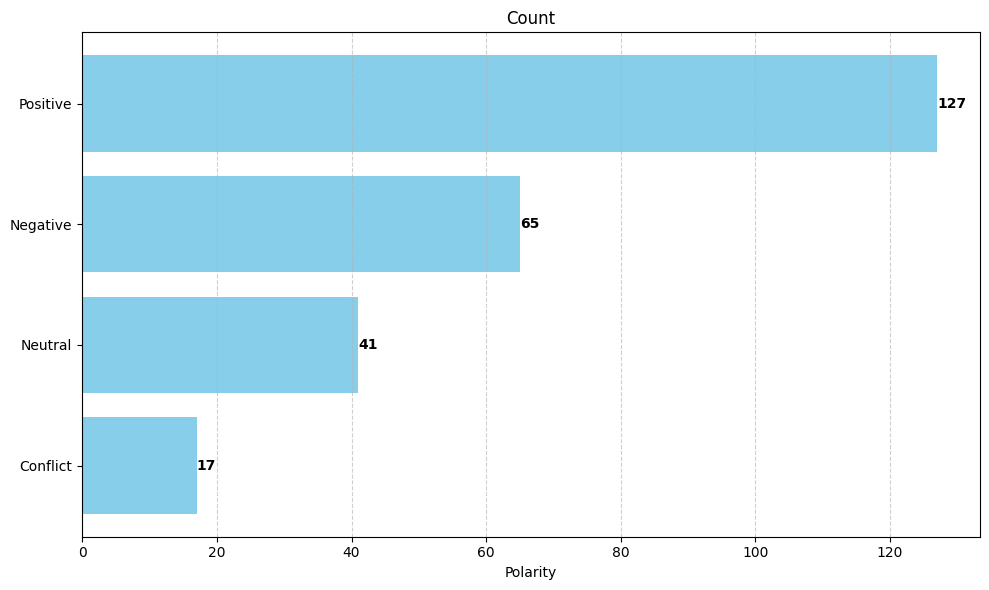

In [55]:
polarity_Category(Process_Category_Dataset,'test')

Conflict:  11  Neutral:  9  Negative:  28  Positive:  67


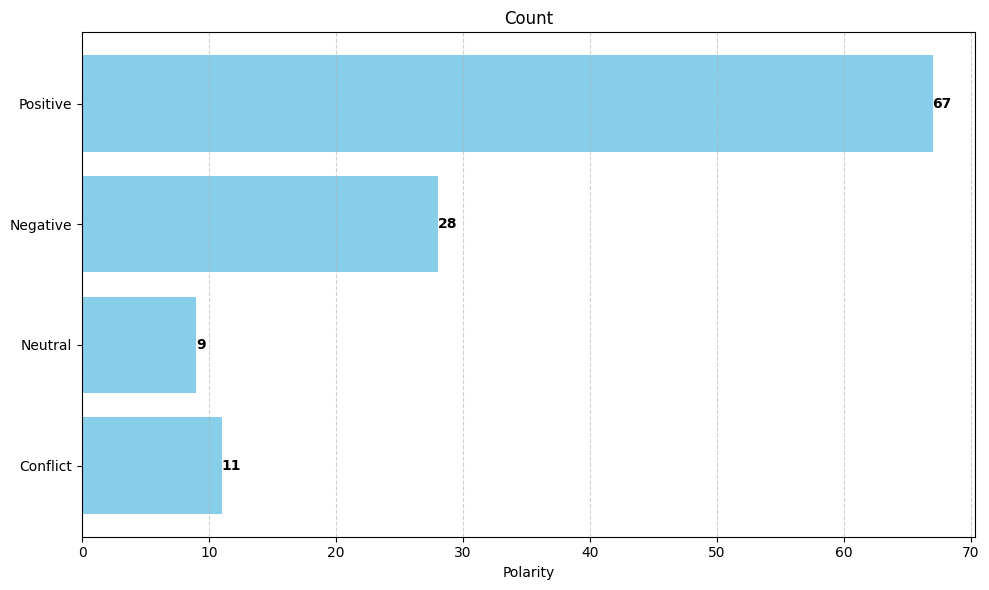

In [56]:
polarity_Category(Process_Category_Dataset,'dev')

In [57]:
def polarity_Category_(dataset,label):
    polarity_label_id= {0:'conflict',1:'neutral',2:'negative',3:'positive'}
    category_label= {0:'ambience', 1:'anecdotes/miscellaneous' ,2: 'food',3: 'price',4: 'service'}
    ds = dataset[label]
    conflict=0
    neutral=0
    negative=0
    positive=0

    ds.set_format(type='pandas')
    df = ds[:]
    for term,polarity,text in zip(df['category_label'],df['polarity_label'],df['text']):
        # print(term,polarity)
        for i,j in zip(polarity,term):
            if polarity_label_id[i] == 'conflict':
                conflict += 1
                print('Text:',text,' Category:',category_label[j],' Polarity:',polarity_label_id[i])
            elif polarity_label_id[i] == 'neutral':
                neutral +=1
            elif polarity_label_id[i] == 'negative':
                negative +=1
            elif polarity_label_id[i] == 'positive':
                positive +=1

        
    print("Conflict: ",conflict," Neutral: ",neutral," Negative: ",negative," Positive: ",positive)

polarity_Category_(Process_Category_Dataset,'test')
Process_Category_Dataset.reset_format()

# text', 'category_label', 'polarity_label'

Text: A little noise but I think that was because of our party!  Category: ambience  Polarity: conflict
Text: My biggest complaint was the un-tasty food although presented well.  Category: food  Polarity: conflict
Text: Small servings for main entree, i had salmon (wasnt impressed) girlfriend had chicken, it was good.  Category: food  Polarity: conflict
Text: The place does get crowded, so I recommend going between 4-5 PM.  Category: ambience  Polarity: conflict
Text: The place was real empty but that was because this was the first Sunday they ever opened.  Category: ambience  Polarity: conflict
Text: The rest of the menu is limited by everything is good eats.  Category: food  Polarity: conflict
Text: Though you will undoubtedly be seated at a table with what seems like barely enough room (no matter what the size of your party), the warm atomosphere is worth the cramped quarters- you'll have fun and forgot about the tight spot you're in.  Category: ambience  Polarity: conflict
Text: Th

#### Conflict signify that the Category and Sentence are in conflecting state

## With this We End EDA and We check below NER Models

List of some Models in Huggingface Hub which will act as starting point for Fine-tuning
- https://huggingface.co/BerserkerMother/restaurant_ner
- https://huggingface.co/dvquys/ner-finetune-restaurant-reviews-aspects (This Model we will use as pre-train)



# 3. Model Training 



In [58]:
def display_model_metric(metrics):
    # Extracting metric names and values
    metrics = {k:v for k,v in metrics.items() if k not in ['test_loss','test_runtime','test_samples_per_second','test_steps_per_second']}
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.barh(metric_names, metric_values, color='skyblue')
    plt.xlabel('Metric')
    plt.title('Count')
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.5f}',
                 va='center', ha='left', color='black', fontweight='bold')

    # Display the chart
    plt.tight_layout()

## 3.1 Definition 1: Aspect term extraction i.e. NER extraction

In [60]:
create_directory(['artifacts/models/ner/epoch','artifacts/models/ner/final'])       

**Some import Function Declaration for NER and Model & Tokenizer Declaration**

In [61]:
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from torch.optim import AdamW
import evaluate
from transformers import TrainingArguments
import os
from dotenv import load_dotenv
import os
import wandb
load_dotenv()
wandb_key = os.getenv('WANDB_API_KEY')

wandb_key = os.getenv('WANDB_API_KEY')
wandb.login(key=wandb_key,relogin=True)

os.environ["WANDB_PROJECT"] = "New_Case_Study17_NER"
os.environ['WANDB_WATCH']= 'all'

label2id = { 'O':0, 'B':1, 'I':2}
id2label={0: 'O', 1: 'B', 2: 'I'}
model_checkpoint = "dvquys/ner-finetune-restaurant-reviews-aspects" #"bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(
                                                            model_checkpoint,
                                                            id2label=id2label,
                                                            label2id=label2id,
                                                            ignore_mismatched_sizes=True
                                                        ) #.to("mps")

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# optimizer = AdamW(model.parameters(), lr=5e-5) #2e-5 - 5e-5

metric = evaluate.load("seqeval")

args = TrainingArguments(
                            output_dir="artifacts/models/ner/epoch",
                            logging_strategy = 'epoch',
                            # save_total_limit= 4,
                            eval_strategy="epoch",
                            save_strategy="epoch",
                            learning_rate=5e-5,
                            num_train_epochs=20,
                            weight_decay=0.01,
                            # use_mps_device=True,
                            greater_is_better=True,
                            load_best_model_at_end=True,
                            metric_for_best_model='f1',
                            warmup_steps=500,
                            run_name = "Run_New_Case_Study17",
                            report_to="wandb",
                        )

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/nabarunbarua/.netrc
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dvquys/ner-finetune-restaurant-reviews-aspects and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([21]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([21, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

##### This function helps during training for computing metric

In [63]:

import numpy as np


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

##### These two function are helper function which helps to adjust Labels for sub-token cases

In [64]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            new_labels.append(-100)
    return new_labels

In [65]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
                                    examples["split_text"], truncation=True, is_split_into_words=True
                                )
    all_labels = examples["ner_label"]
    new_labels = []  	
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

##### Tokenizing the NER Dataset

In [66]:
Process_NER_Dataset.reset_format()
tokenized_datasets = Process_NER_Dataset.map(
                                        tokenize_and_align_labels,
                                        batched=True,
                                        remove_columns=Process_NER_Dataset["train"].column_names,
                                    )

Map:   0%|          | 0/2736 [00:00<?, ? examples/s]

Map: 100%|██████████| 92/92 [00:00<00:00, 16239.89 examples/s]


In [67]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2736
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 213
    })
    dev: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 92
    })
})

##### Data Loader Declaration

In [68]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
                                tokenized_datasets["train"],
                                shuffle=True,
                                collate_fn=data_collator,
                                batch_size=8,
                            )
eval_dataloader = DataLoader(
                                tokenized_datasets["test"], 
                                collate_fn=data_collator, 
                                batch_size=8
                            )

##### Trainer API Execution

In [69]:
from transformers import Trainer
# from transformers import EarlyStoppingCallback

# erly_stp_clb = EarlyStoppingCallback(early_stopping_patience=3)
trainer = Trainer(
                    model=model,
                    args=args,
                    train_dataset=tokenized_datasets["train"],
                    eval_dataset=tokenized_datasets["test"],
                    data_collator=data_collator,
                    compute_metrics=compute_metrics,
                    tokenizer=tokenizer,
                    # callbacks=[erly_stp_clb],
                )
trainer.train()

wandb: Currently logged in as: nabarunbarua. Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  5%|▌         | 342/6840 [00:56<13:43,  7.89it/s]

{'loss': 0.234, 'grad_norm': 1.702453851699829, 'learning_rate': 3.4200000000000005e-05, 'epoch': 1.0}


                                                  
  5%|▌         | 342/6840 [00:57<13:43,  7.89it/s]

{'eval_loss': 0.0809420570731163, 'eval_precision': 0.8095238095238095, 'eval_recall': 0.8565891472868217, 'eval_f1': 0.832391713747646, 'eval_accuracy': 0.9719973009446694, 'eval_runtime': 1.7991, 'eval_samples_per_second': 118.393, 'eval_steps_per_second': 15.008, 'epoch': 1.0}


 10%|█         | 684/6840 [01:46<13:04,  7.85it/s]  

{'loss': 0.0813, 'grad_norm': 2.024123430252075, 'learning_rate': 4.854889589905363e-05, 'epoch': 2.0}


                                                  
 10%|█         | 684/6840 [01:47<13:04,  7.85it/s]

{'eval_loss': 0.08223991096019745, 'eval_precision': 0.8195488721804511, 'eval_recall': 0.8449612403100775, 'eval_f1': 0.8320610687022901, 'eval_accuracy': 0.9723346828609987, 'eval_runtime': 0.9917, 'eval_samples_per_second': 214.779, 'eval_steps_per_second': 27.226, 'epoch': 2.0}


 15%|█▌        | 1026/6840 [02:32<11:44,  8.25it/s] 

{'loss': 0.0399, 'grad_norm': 4.469663143157959, 'learning_rate': 4.5851735015772874e-05, 'epoch': 3.0}


                                                   
 15%|█▌        | 1026/6840 [02:33<11:44,  8.25it/s]

{'eval_loss': 0.09652528166770935, 'eval_precision': 0.825925925925926, 'eval_recall': 0.8643410852713178, 'eval_f1': 0.8446969696969696, 'eval_accuracy': 0.9730094466936572, 'eval_runtime': 0.9838, 'eval_samples_per_second': 216.507, 'eval_steps_per_second': 27.445, 'epoch': 3.0}


 20%|██        | 1368/6840 [03:18<11:02,  8.26it/s]  

{'loss': 0.0241, 'grad_norm': 5.05463981628418, 'learning_rate': 4.315457413249211e-05, 'epoch': 4.0}


                                                   
 20%|██        | 1368/6840 [03:19<11:02,  8.26it/s]

{'eval_loss': 0.09850039333105087, 'eval_precision': 0.8396946564885496, 'eval_recall': 0.8527131782945736, 'eval_f1': 0.8461538461538461, 'eval_accuracy': 0.9736842105263158, 'eval_runtime': 1.0056, 'eval_samples_per_second': 211.817, 'eval_steps_per_second': 26.85, 'epoch': 4.0}


 25%|██▌       | 1710/6840 [04:05<09:34,  8.94it/s]  

{'loss': 0.0135, 'grad_norm': 10.732354164123535, 'learning_rate': 4.0457413249211356e-05, 'epoch': 5.0}


                                                   
 25%|██▌       | 1710/6840 [04:06<09:34,  8.94it/s]

{'eval_loss': 0.11254207789897919, 'eval_precision': 0.8315018315018315, 'eval_recall': 0.8798449612403101, 'eval_f1': 0.8549905838041433, 'eval_accuracy': 0.9753711201079622, 'eval_runtime': 1.0158, 'eval_samples_per_second': 209.678, 'eval_steps_per_second': 26.579, 'epoch': 5.0}


 30%|███       | 2052/6840 [04:52<10:14,  7.79it/s]  

{'loss': 0.0096, 'grad_norm': 0.1329270601272583, 'learning_rate': 3.77602523659306e-05, 'epoch': 6.0}


                                                   
 30%|███       | 2052/6840 [04:53<10:14,  7.79it/s]

{'eval_loss': 0.12419549375772476, 'eval_precision': 0.8389513108614233, 'eval_recall': 0.8682170542635659, 'eval_f1': 0.8533333333333333, 'eval_accuracy': 0.9733468286099866, 'eval_runtime': 1.0904, 'eval_samples_per_second': 195.337, 'eval_steps_per_second': 24.761, 'epoch': 6.0}


 35%|███▌      | 2394/6840 [05:42<10:45,  6.89it/s]  

{'loss': 0.0058, 'grad_norm': 0.0032866813708096743, 'learning_rate': 3.5063091482649845e-05, 'epoch': 7.0}


                                                   
 35%|███▌      | 2394/6840 [05:43<10:45,  6.89it/s]

{'eval_loss': 0.12801840901374817, 'eval_precision': 0.8198529411764706, 'eval_recall': 0.8643410852713178, 'eval_f1': 0.8415094339622641, 'eval_accuracy': 0.9740215924426451, 'eval_runtime': 1.169, 'eval_samples_per_second': 182.21, 'eval_steps_per_second': 23.097, 'epoch': 7.0}


 40%|████      | 2736/6840 [06:33<09:45,  7.01it/s]  

{'loss': 0.0031, 'grad_norm': 0.0007475335150957108, 'learning_rate': 3.236593059936909e-05, 'epoch': 8.0}


                                                   
 40%|████      | 2736/6840 [06:34<09:45,  7.01it/s]

{'eval_loss': 0.1790892779827118, 'eval_precision': 0.843065693430657, 'eval_recall': 0.8953488372093024, 'eval_f1': 0.868421052631579, 'eval_accuracy': 0.9767206477732794, 'eval_runtime': 1.0562, 'eval_samples_per_second': 201.672, 'eval_steps_per_second': 25.564, 'epoch': 8.0}


 45%|████▌     | 3078/6840 [07:23<07:37,  8.22it/s]  

{'loss': 0.0028, 'grad_norm': 0.014210688881576061, 'learning_rate': 2.966876971608833e-05, 'epoch': 9.0}


                                                   
 45%|████▌     | 3078/6840 [07:24<07:37,  8.22it/s]

{'eval_loss': 0.17291969060897827, 'eval_precision': 0.8290909090909091, 'eval_recall': 0.8837209302325582, 'eval_f1': 0.8555347091932458, 'eval_accuracy': 0.9763832658569501, 'eval_runtime': 1.0245, 'eval_samples_per_second': 207.911, 'eval_steps_per_second': 26.355, 'epoch': 9.0}


 50%|█████     | 3420/6840 [08:11<07:46,  7.33it/s]  

{'loss': 0.0034, 'grad_norm': 0.0013498531188815832, 'learning_rate': 2.697160883280757e-05, 'epoch': 10.0}


                                                   
 50%|█████     | 3420/6840 [08:12<07:46,  7.33it/s]

{'eval_loss': 0.16390608251094818, 'eval_precision': 0.8211678832116789, 'eval_recall': 0.872093023255814, 'eval_f1': 0.8458646616541353, 'eval_accuracy': 0.9733468286099866, 'eval_runtime': 1.0206, 'eval_samples_per_second': 208.691, 'eval_steps_per_second': 26.454, 'epoch': 10.0}


 55%|█████▌    | 3762/6840 [08:58<06:38,  7.72it/s]  

{'loss': 0.0023, 'grad_norm': 0.0026375881861895323, 'learning_rate': 2.4274447949526815e-05, 'epoch': 11.0}


                                                   
 55%|█████▌    | 3762/6840 [08:59<06:38,  7.72it/s]

{'eval_loss': 0.1888185292482376, 'eval_precision': 0.8407407407407408, 'eval_recall': 0.8798449612403101, 'eval_f1': 0.8598484848484849, 'eval_accuracy': 0.9740215924426451, 'eval_runtime': 1.0017, 'eval_samples_per_second': 212.631, 'eval_steps_per_second': 26.953, 'epoch': 11.0}


 60%|██████    | 4104/6840 [09:44<05:32,  8.22it/s]

{'loss': 0.0021, 'grad_norm': 0.457019567489624, 'learning_rate': 2.1577287066246056e-05, 'epoch': 12.0}


                                                   
 60%|██████    | 4104/6840 [09:46<05:32,  8.22it/s]

{'eval_loss': 0.18690606951713562, 'eval_precision': 0.8505747126436781, 'eval_recall': 0.8604651162790697, 'eval_f1': 0.8554913294797688, 'eval_accuracy': 0.9760458839406208, 'eval_runtime': 1.0211, 'eval_samples_per_second': 208.602, 'eval_steps_per_second': 26.443, 'epoch': 12.0}


 65%|██████▌   | 4446/6840 [10:31<04:49,  8.26it/s]

{'loss': 0.0008, 'grad_norm': 0.00035859449417330325, 'learning_rate': 1.88801261829653e-05, 'epoch': 13.0}


                                                   
 65%|██████▌   | 4446/6840 [10:32<04:49,  8.26it/s]

{'eval_loss': 0.19559204578399658, 'eval_precision': 0.8560311284046692, 'eval_recall': 0.8527131782945736, 'eval_f1': 0.8543689320388349, 'eval_accuracy': 0.9767206477732794, 'eval_runtime': 0.9871, 'eval_samples_per_second': 215.774, 'eval_steps_per_second': 27.352, 'epoch': 13.0}


 70%|███████   | 4788/6840 [11:18<04:25,  7.72it/s]

{'loss': 0.0011, 'grad_norm': 0.0002805539988912642, 'learning_rate': 1.6182965299684544e-05, 'epoch': 14.0}


                                                   
 70%|███████   | 4788/6840 [11:19<04:25,  7.72it/s]

{'eval_loss': 0.19618672132492065, 'eval_precision': 0.8438661710037175, 'eval_recall': 0.8798449612403101, 'eval_f1': 0.8614800759013284, 'eval_accuracy': 0.9777327935222672, 'eval_runtime': 1.0152, 'eval_samples_per_second': 209.815, 'eval_steps_per_second': 26.596, 'epoch': 14.0}


 75%|███████▌  | 5130/6840 [12:04<03:43,  7.64it/s]

{'loss': 0.001, 'grad_norm': 0.0005137368571013212, 'learning_rate': 1.3485804416403785e-05, 'epoch': 15.0}


                                                   
 75%|███████▌  | 5130/6840 [12:05<03:43,  7.64it/s]

{'eval_loss': 0.21098463237285614, 'eval_precision': 0.8231046931407943, 'eval_recall': 0.8837209302325582, 'eval_f1': 0.852336448598131, 'eval_accuracy': 0.975033738191633, 'eval_runtime': 1.0611, 'eval_samples_per_second': 200.733, 'eval_steps_per_second': 25.445, 'epoch': 15.0}


 80%|████████  | 5472/6840 [12:49<02:47,  8.18it/s]

{'loss': 0.0001, 'grad_norm': 0.00018601342162583023, 'learning_rate': 1.0788643533123028e-05, 'epoch': 16.0}


                                                   
 80%|████████  | 5472/6840 [12:50<02:47,  8.18it/s]

{'eval_loss': 0.21672721207141876, 'eval_precision': 0.8248175182481752, 'eval_recall': 0.875968992248062, 'eval_f1': 0.849624060150376, 'eval_accuracy': 0.975033738191633, 'eval_runtime': 1.015, 'eval_samples_per_second': 209.848, 'eval_steps_per_second': 26.6, 'epoch': 16.0}


 85%|████████▌ | 5814/6840 [13:36<02:01,  8.41it/s]

{'loss': 0.0007, 'grad_norm': 0.00038987654261291027, 'learning_rate': 8.091482649842272e-06, 'epoch': 17.0}


                                                   
 85%|████████▌ | 5814/6840 [13:37<02:01,  8.41it/s]

{'eval_loss': 0.22257347404956818, 'eval_precision': 0.8093525179856115, 'eval_recall': 0.872093023255814, 'eval_f1': 0.8395522388059701, 'eval_accuracy': 0.9746963562753036, 'eval_runtime': 0.9982, 'eval_samples_per_second': 213.376, 'eval_steps_per_second': 27.048, 'epoch': 17.0}


 90%|█████████ | 6156/6840 [14:23<01:27,  7.84it/s]

{'loss': 0.0002, 'grad_norm': 0.00023518035595770925, 'learning_rate': 5.394321766561514e-06, 'epoch': 18.0}


                                                   
 90%|█████████ | 6156/6840 [14:24<01:27,  7.84it/s]

{'eval_loss': 0.2130986601114273, 'eval_precision': 0.8272058823529411, 'eval_recall': 0.872093023255814, 'eval_f1': 0.8490566037735848, 'eval_accuracy': 0.9760458839406208, 'eval_runtime': 0.9834, 'eval_samples_per_second': 216.604, 'eval_steps_per_second': 27.457, 'epoch': 18.0}


 95%|█████████▌| 6498/6840 [15:09<00:42,  8.13it/s]

{'loss': 0.0001, 'grad_norm': 0.0001410053373547271, 'learning_rate': 2.697160883280757e-06, 'epoch': 19.0}


                                                   
 95%|█████████▌| 6498/6840 [15:10<00:42,  8.13it/s]

{'eval_loss': 0.2127051204442978, 'eval_precision': 0.8388278388278388, 'eval_recall': 0.8875968992248062, 'eval_f1': 0.8625235404896422, 'eval_accuracy': 0.9770580296896086, 'eval_runtime': 1.5545, 'eval_samples_per_second': 137.02, 'eval_steps_per_second': 17.369, 'epoch': 19.0}


100%|██████████| 6840/6840 [15:58<00:00,  7.62it/s]

{'loss': 0.0001, 'grad_norm': 0.00015614771109540015, 'learning_rate': 0.0, 'epoch': 20.0}


                                                   
100%|██████████| 6840/6840 [15:59<00:00,  7.62it/s]

{'eval_loss': 0.21212872862815857, 'eval_precision': 0.8419117647058824, 'eval_recall': 0.8875968992248062, 'eval_f1': 0.8641509433962264, 'eval_accuracy': 0.9773954116059379, 'eval_runtime': 1.1807, 'eval_samples_per_second': 180.406, 'eval_steps_per_second': 22.868, 'epoch': 20.0}


100%|██████████| 6840/6840 [16:01<00:00,  7.11it/s]

{'train_runtime': 962.387, 'train_samples_per_second': 56.859, 'train_steps_per_second': 7.107, 'train_loss': 0.02130259264924983, 'epoch': 20.0}


TrainOutput(global_step=6840, training_loss=0.02130259264924983, metrics={'train_runtime': 962.387, 'train_samples_per_second': 56.859, 'train_steps_per_second': 7.107, 'total_flos': 1000767460570848.0, 'train_loss': 0.02130259264924983, 'epoch': 20.0})

##### Checking Best Model on Test Set i.e of Epoch 8

100%|██████████| 27/27 [00:01<00:00, 26.39it/s]


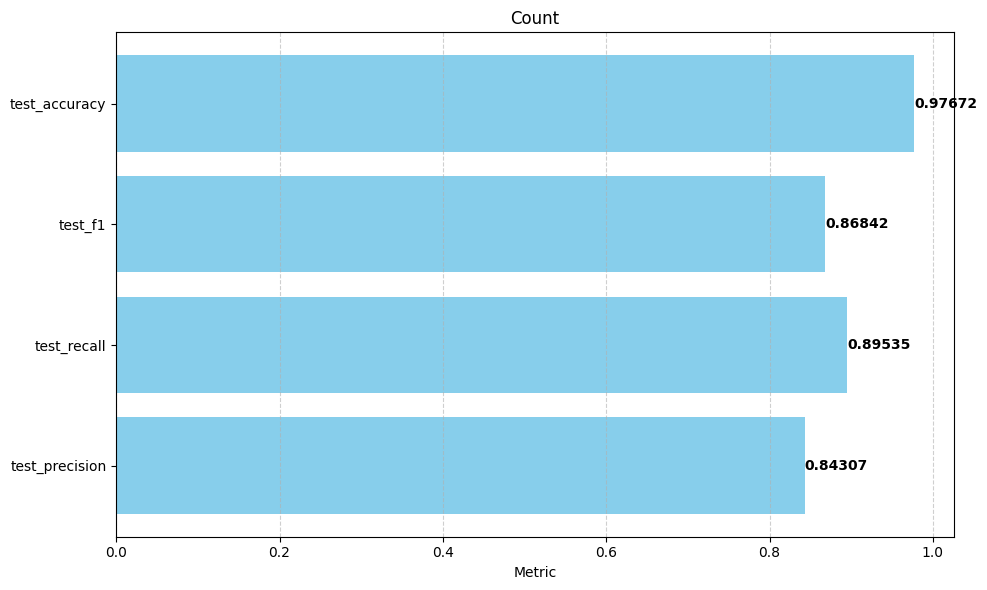

In [112]:
# from pprint import pprint
# pprint(trainer.predict(test_dataset=tokenized_datasets["test"]))
result =trainer.predict(test_dataset=tokenized_datasets["test"])

display_model_metric(result.metrics)

##### Checking Best Model on Unseen Set

100%|██████████| 12/12 [00:00<00:00, 28.44it/s]


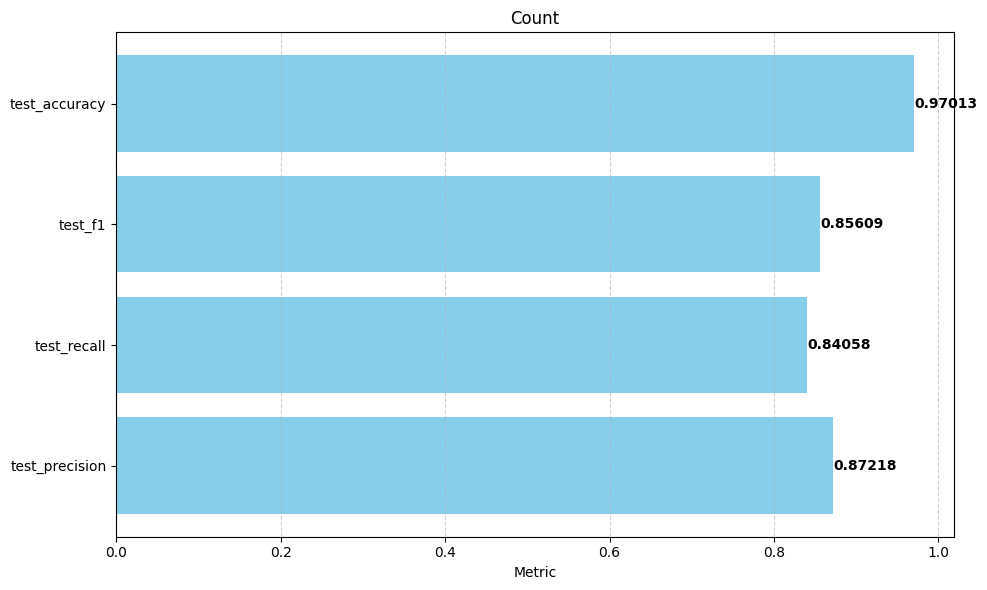

In [113]:
# from pprint import pprint
# pprint(trainer.predict(test_dataset=tokenized_datasets["dev"]))

result =trainer.predict(test_dataset=tokenized_datasets["dev"])

display_model_metric(result.metrics)

## Saving the Best Model i.e. Epoch 8 which has the highest F1 Score.
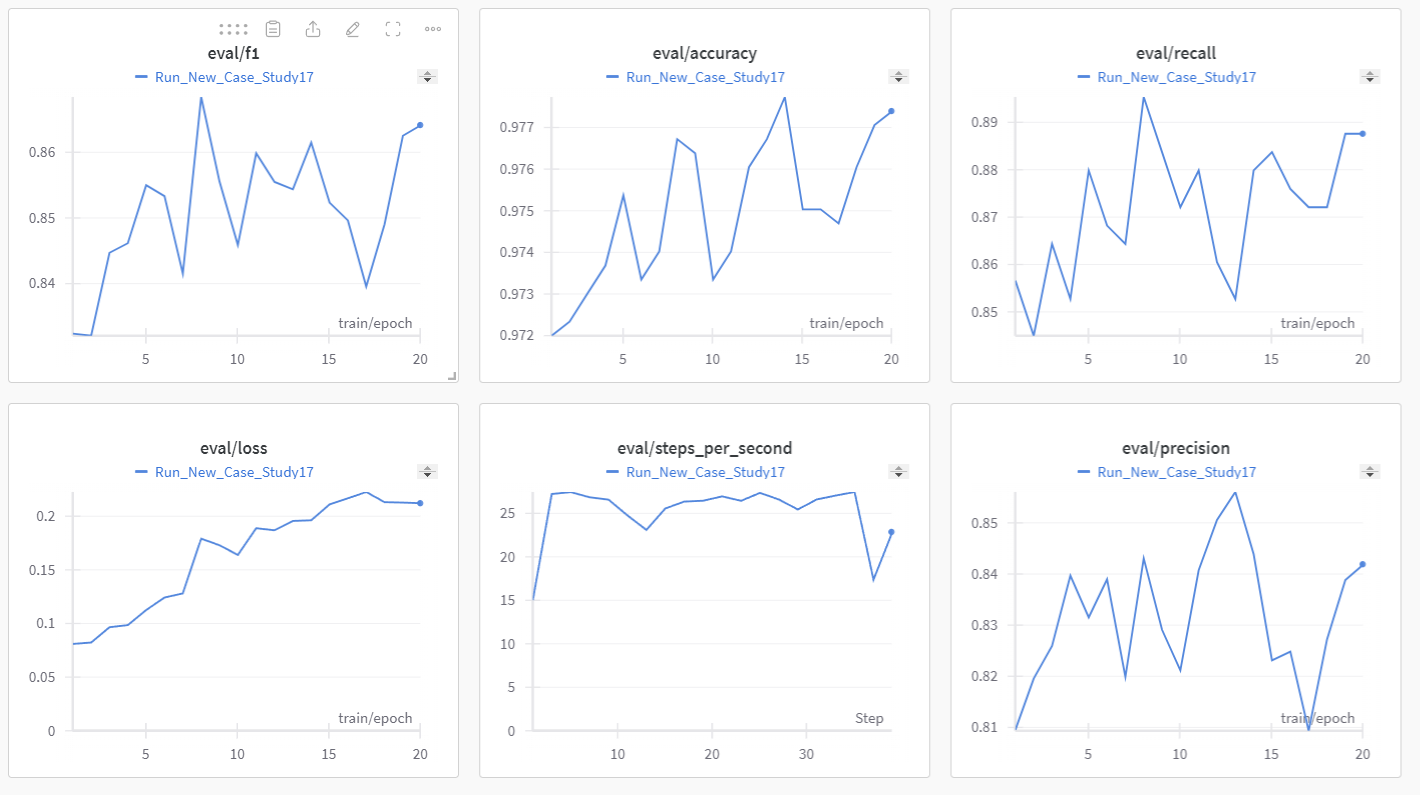

## Training Loss
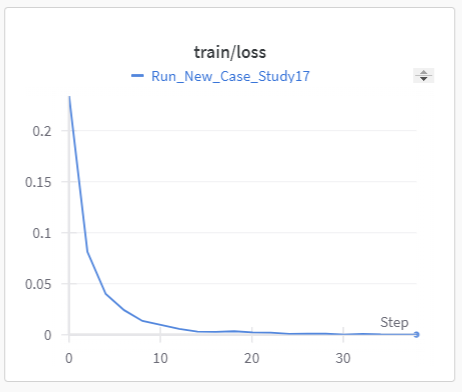

In [114]:
# trainer.model.save_pretrained('artifacts/models/ner/final')
tokenizer.save_pretrained('artifacts/models/ner/final')
trainer.save_model('artifacts/models/ner/final')

### From the above Graph we can see that at Epoch 8 we got the Highest F1 Score. I selcted F1 Score as my Metric because I wanted the balance trade-off between the precision and recall.



## 3.2 Definition 3: Aspect category detection i.e.Multi-Label Classification. 



The Input Text would be Classify into multiple label i.e. {'ambience': 0,'anecdotes/miscellaneous': 1,'food': 2, 'price': 3, 'service': 4}

#### First we will load the Model and Tokenizer

In [61]:
create_directory(['artifacts/models/category/epoch','artifacts/models/category/final'])       

In [62]:
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
# from transformers import DataCollatorForTokenClassification
from torch.optim import AdamW

from transformers import TrainingArguments
import os
from dotenv import load_dotenv
import os
import wandb
from transformers import DataCollatorWithPadding

from transformers import AutoModelForSequenceClassification #, TrainingArguments, Trainer


load_dotenv()
wandb_key = os.getenv('WANDB_API_KEY')

wandb_key = os.getenv('WANDB_API_KEY')
wandb.login(key=wandb_key,relogin=True)

os.environ["WANDB_PROJECT"] = "New_Case_Study_Multi"
os.environ['WANDB_WATCH']= 'all'

label2id = {'ambience': 0,'anecdotes/miscellaneous': 1,'food': 2, 'price': 3, 'service': 4}
id2label={0:'ambience',1:'anecdotes/miscellaneous',2:'food', 3:'price', 4:'service'}
model_checkpoint = "dvquys/ner-finetune-restaurant-reviews-aspects" #"bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(
                                                            model_checkpoint, 
                                                            num_labels=len(label2id),
                                                            id2label=id2label, 
                                                            label2id=label2id,
                                                            problem_type = "multi_label_classification",
                                                            ignore_mismatched_sizes=True
                                                        )


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)



args = TrainingArguments(
                            output_dir="artifacts/models/category/epoch",
                            logging_strategy = 'epoch',
                            # save_total_limit= 4,
                            eval_strategy="epoch",
                            save_strategy="epoch",
                            learning_rate=5e-5,
                            num_train_epochs=20,
                            weight_decay=0.01,
                            # use_mps_device=True,
                            greater_is_better=True,
                            load_best_model_at_end=True,
                            metric_for_best_model='f1',
                            warmup_steps=500,
                            run_name = "Run_Multi_Case_Study",
                            report_to="wandb",
                        )

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/nabarunbarua/.netrc
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dvquys/ner-finetune-restaurant-reviews-aspects and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dvquys/ner-finetune-restaurant-reviews-aspects and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([21])

##### Since it is Multi-Label Classification therefore we need to one-hot encode our Target Label

In [63]:
import numpy as np
def one_hot_encoding(examples):
    total_label = len(label2id)
    label_matrix = np.zeros((len(examples['text']),total_label))
    
    for ran,cat in zip(range(len(examples['text'])),examples['category_label']):
        for i in cat:
            label_matrix[ran,i]= 1.
    
    examples['new_category_label'] = label_matrix
    return examples
            

Process_Category_Dataset.reset_format()
Process_Category_Dataset= Process_Category_Dataset.map(one_hot_encoding,batched=True)
Process_Category_Dataset


Map: 100%|██████████| 92/92 [00:00<00:00, 29795.07 examples/s]


DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'category_label', 'polarity_label', 'new_category_label'],
        num_rows: 2736
    })
    test: Dataset({
        features: ['ID', 'text', 'category_label', 'polarity_label', 'new_category_label'],
        num_rows: 213
    })
    dev: Dataset({
        features: ['ID', 'text', 'category_label', 'polarity_label', 'new_category_label'],
        num_rows: 92
    })
})

In [64]:
Process_Category_Dataset['train'][12] 

{'ID': '489',
 'text': "Katz's has been a NYC original for over 100 years.",
 'category_label': [1],
 'polarity_label': [3],
 'new_category_label': [0.0, 1.0, 0.0, 0.0, 0.0]}

##### Utility Function for tokenizing the Inputs

In [65]:
def tokenize_multi(examples):
    tokenized_inputs = tokenizer(
                                    examples['text'], truncation=True 
                                )
    tokenized_inputs['labels'] = examples['new_category_label']
    return tokenized_inputs

In [66]:
Process_Category_Dataset.reset_format()
tokenized_datasets = Process_Category_Dataset.map(
                                                    tokenize_multi,
                                                    batched=True,
                                                    remove_columns=Process_Category_Dataset["train"].column_names,
                                                )

Map: 100%|██████████| 92/92 [00:00<00:00, 23075.95 examples/s]


In [67]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2736
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 213
    })
    dev: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 92
    })
})

##### Data Loader Declaration

In [68]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
                                tokenized_datasets["train"],
                                shuffle=True,
                                collate_fn=data_collator,
                                batch_size=8,
                            )
eval_dataloader = DataLoader(
                                tokenized_datasets["test"], 
                                collate_fn=data_collator, 
                                batch_size=8
                            )

##### This function helps during training for computing metric

In [69]:
import torch
# import evaluate
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# metric = evaluate.combine(["accuracy", "f1", "precision", "recall"])
# metric_f1 = evaluate.load("f1")
def compute_metrics(eval_preds):
    threshhold =0.5
    predictions, labels = eval_preds
    sigmoid = torch.nn.Sigmoid()
    pred = sigmoid(torch.Tensor(predictions))
    predictions = np.zeros(pred.shape)
    predictions[np.where(pred >= threshhold)] = 1.

    f1 = f1_score(y_true=labels, y_pred=predictions, average='macro')
    precision = precision_score(y_true=labels, y_pred=predictions, average='macro')
    recall = recall_score(y_true=labels, y_pred=predictions, average='macro')
    accuracy = accuracy_score(y_true=labels, y_pred=predictions)
    result = {'f1':f1,
              'recall':recall,
              'precision':precision,
              'accuracy':accuracy}
    
    # predictions = predictions.astype(int).reshape(-1)
    # labels = labels.astype(int).reshape(-1)
    # result = metric.compute(predictions=predictions,references=labels)
    return result

##### Training Execution

In [70]:
from transformers import Trainer
# from transformers import EarlyStoppingCallback

# erly_stp_clb = EarlyStoppingCallback(early_stopping_patience=3)
trainer = Trainer(
                    model=model,
                    args=args,
                    train_dataset=tokenized_datasets["train"],
                    eval_dataset=tokenized_datasets["test"],
                    data_collator=data_collator,
                    compute_metrics=compute_metrics,
                    tokenizer=tokenizer,
                    # callbacks=[erly_stp_clb],
                )
trainer.train()

wandb: Currently logged in as: nabarunbarua. Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  5%|▌         | 342/6840 [00:51<12:57,  8.36it/s]

{'loss': 0.3716, 'grad_norm': 1.1984460353851318, 'learning_rate': 3.4200000000000005e-05, 'epoch': 1.0}


                                                  
  5%|▌         | 342/6840 [00:53<12:57,  8.36it/s]

{'eval_loss': 0.1994151920080185, 'eval_f1': 0.8338167583975865, 'eval_recall': 0.7874196895936028, 'eval_precision': 0.9217220762750248, 'eval_accuracy': 0.7981220657276995, 'eval_runtime': 2.019, 'eval_samples_per_second': 105.497, 'eval_steps_per_second': 13.373, 'epoch': 1.0}


 10%|█         | 684/6840 [01:39<13:15,  7.73it/s]  

{'loss': 0.1909, 'grad_norm': 4.08001184463501, 'learning_rate': 4.854889589905363e-05, 'epoch': 2.0}


                                                  
 10%|█         | 684/6840 [01:41<13:15,  7.73it/s]

{'eval_loss': 0.1847967952489853, 'eval_f1': 0.8482011430238667, 'eval_recall': 0.8406654254480342, 'eval_precision': 0.8615288220551378, 'eval_accuracy': 0.7934272300469484, 'eval_runtime': 1.1686, 'eval_samples_per_second': 182.272, 'eval_steps_per_second': 23.105, 'epoch': 2.0}


 15%|█▌        | 1026/6840 [02:26<11:45,  8.24it/s] 

{'loss': 0.1144, 'grad_norm': 1.3990510702133179, 'learning_rate': 4.5851735015772874e-05, 'epoch': 3.0}


                                                   
 15%|█▌        | 1026/6840 [02:27<11:45,  8.24it/s]

{'eval_loss': 0.18392466008663177, 'eval_f1': 0.8486946009964879, 'eval_recall': 0.8546535524796395, 'eval_precision': 0.844353200073354, 'eval_accuracy': 0.7652582159624414, 'eval_runtime': 1.0878, 'eval_samples_per_second': 195.809, 'eval_steps_per_second': 24.821, 'epoch': 3.0}


 20%|██        | 1368/6840 [03:11<10:47,  8.46it/s]  

{'loss': 0.0701, 'grad_norm': 5.8563079833984375, 'learning_rate': 4.315457413249211e-05, 'epoch': 4.0}


                                                   
 20%|██        | 1368/6840 [03:12<10:47,  8.46it/s]

{'eval_loss': 0.19602318108081818, 'eval_f1': 0.872817355824538, 'eval_recall': 0.887725670334366, 'eval_precision': 0.8624380262615556, 'eval_accuracy': 0.8215962441314554, 'eval_runtime': 1.1079, 'eval_samples_per_second': 192.252, 'eval_steps_per_second': 24.37, 'epoch': 4.0}


 25%|██▌       | 1710/6840 [03:58<10:01,  8.53it/s]  

{'loss': 0.0488, 'grad_norm': 0.03779670223593712, 'learning_rate': 4.0457413249211356e-05, 'epoch': 5.0}


                                                   
 25%|██▌       | 1710/6840 [03:59<10:01,  8.53it/s]

{'eval_loss': 0.17331139743328094, 'eval_f1': 0.8746639176800048, 'eval_recall': 0.8736599671382279, 'eval_precision': 0.8768189399555226, 'eval_accuracy': 0.7981220657276995, 'eval_runtime': 1.3025, 'eval_samples_per_second': 163.537, 'eval_steps_per_second': 20.73, 'epoch': 5.0}


 30%|███       | 2052/6840 [04:49<12:46,  6.25it/s]  

{'loss': 0.0279, 'grad_norm': 0.042080748826265335, 'learning_rate': 3.77602523659306e-05, 'epoch': 6.0}


                                                   
 30%|███       | 2052/6840 [04:50<12:46,  6.25it/s]

{'eval_loss': 0.23742322623729706, 'eval_f1': 0.8697635653766096, 'eval_recall': 0.8974577909360517, 'eval_precision': 0.8439199640356291, 'eval_accuracy': 0.7887323943661971, 'eval_runtime': 1.2916, 'eval_samples_per_second': 164.914, 'eval_steps_per_second': 20.905, 'epoch': 6.0}


 35%|███▌      | 2394/6840 [05:39<10:20,  7.16it/s]  

{'loss': 0.0157, 'grad_norm': 4.029539585113525, 'learning_rate': 3.5063091482649845e-05, 'epoch': 7.0}


                                                   
 35%|███▌      | 2394/6840 [05:40<10:20,  7.16it/s]

{'eval_loss': 0.2327449917793274, 'eval_f1': 0.8917100193224068, 'eval_recall': 0.9345308040960214, 'eval_precision': 0.8536535238398593, 'eval_accuracy': 0.812206572769953, 'eval_runtime': 1.2166, 'eval_samples_per_second': 175.084, 'eval_steps_per_second': 22.194, 'epoch': 7.0}


 40%|████      | 2736/6840 [06:30<10:12,  6.70it/s]  

{'loss': 0.01, 'grad_norm': 0.00923002790659666, 'learning_rate': 3.236593059936909e-05, 'epoch': 8.0}


                                                   
 40%|████      | 2736/6840 [06:32<10:12,  6.70it/s]

{'eval_loss': 0.2510024309158325, 'eval_f1': 0.8907661543335041, 'eval_recall': 0.9007315050793311, 'eval_precision': 0.8824506928871255, 'eval_accuracy': 0.8309859154929577, 'eval_runtime': 1.2722, 'eval_samples_per_second': 167.427, 'eval_steps_per_second': 21.223, 'epoch': 8.0}


 45%|████▌     | 3078/6840 [07:23<08:29,  7.39it/s]  

{'loss': 0.0042, 'grad_norm': 0.01657402515411377, 'learning_rate': 2.966876971608833e-05, 'epoch': 9.0}


                                                   
 45%|████▌     | 3078/6840 [07:24<08:29,  7.39it/s]

{'eval_loss': 0.2762839198112488, 'eval_f1': 0.8805206285427281, 'eval_recall': 0.923258860215382, 'eval_precision': 0.8437215932306309, 'eval_accuracy': 0.8028169014084507, 'eval_runtime': 1.2016, 'eval_samples_per_second': 177.264, 'eval_steps_per_second': 22.47, 'epoch': 9.0}


 50%|█████     | 3420/6840 [08:13<07:29,  7.60it/s]  

{'loss': 0.0028, 'grad_norm': 0.005060809198766947, 'learning_rate': 2.697160883280757e-05, 'epoch': 10.0}


                                                   
 50%|█████     | 3420/6840 [08:14<07:29,  7.60it/s]

{'eval_loss': 0.25507014989852905, 'eval_f1': 0.8870873228081798, 'eval_recall': 0.8922652748739704, 'eval_precision': 0.882972582972583, 'eval_accuracy': 0.8356807511737089, 'eval_runtime': 1.0999, 'eval_samples_per_second': 193.652, 'eval_steps_per_second': 24.547, 'epoch': 10.0}


 55%|█████▌    | 3762/6840 [09:01<06:59,  7.34it/s]  

{'loss': 0.0028, 'grad_norm': 0.029008015990257263, 'learning_rate': 2.4274447949526815e-05, 'epoch': 11.0}


                                                   
 55%|█████▌    | 3762/6840 [09:02<06:59,  7.34it/s]

{'eval_loss': 0.2648375928401947, 'eval_f1': 0.889840313712555, 'eval_recall': 0.9022125739517044, 'eval_precision': 0.8789767759780001, 'eval_accuracy': 0.8356807511737089, 'eval_runtime': 1.1009, 'eval_samples_per_second': 193.475, 'eval_steps_per_second': 24.525, 'epoch': 11.0}


 60%|██████    | 4104/6840 [09:47<05:34,  8.17it/s]

{'loss': 0.0018, 'grad_norm': 0.2551535964012146, 'learning_rate': 2.1577287066246056e-05, 'epoch': 12.0}


                                                   
 60%|██████    | 4104/6840 [09:48<05:34,  8.17it/s]

{'eval_loss': 0.2681978642940521, 'eval_f1': 0.8818778024143878, 'eval_recall': 0.9076767337636902, 'eval_precision': 0.8607389378903623, 'eval_accuracy': 0.8262910798122066, 'eval_runtime': 1.11, 'eval_samples_per_second': 191.891, 'eval_steps_per_second': 24.324, 'epoch': 12.0}


 65%|██████▌   | 4446/6840 [10:33<04:50,  8.24it/s]

{'loss': 0.0014, 'grad_norm': 0.027223285287618637, 'learning_rate': 1.88801261829653e-05, 'epoch': 13.0}


                                                   
 65%|██████▌   | 4446/6840 [10:34<04:50,  8.24it/s]

{'eval_loss': 0.27249759435653687, 'eval_f1': 0.8991692134158956, 'eval_recall': 0.9232987928640103, 'eval_precision': 0.878303588994126, 'eval_accuracy': 0.8262910798122066, 'eval_runtime': 1.1039, 'eval_samples_per_second': 192.949, 'eval_steps_per_second': 24.458, 'epoch': 13.0}


 70%|███████   | 4788/6840 [11:20<04:22,  7.82it/s]

{'loss': 0.0013, 'grad_norm': 0.00546918623149395, 'learning_rate': 1.6182965299684544e-05, 'epoch': 14.0}


                                                   
 70%|███████   | 4788/6840 [11:21<04:22,  7.82it/s]

{'eval_loss': 0.2960469126701355, 'eval_f1': 0.887291449702287, 'eval_recall': 0.9059074885161842, 'eval_precision': 0.8716982195176921, 'eval_accuracy': 0.8403755868544601, 'eval_runtime': 1.0997, 'eval_samples_per_second': 193.689, 'eval_steps_per_second': 24.552, 'epoch': 14.0}


 75%|███████▌  | 5130/6840 [12:06<03:41,  7.73it/s]

{'loss': 0.0006, 'grad_norm': 0.006597725208848715, 'learning_rate': 1.3485804416403785e-05, 'epoch': 15.0}


                                                   
 75%|███████▌  | 5130/6840 [12:07<03:41,  7.73it/s]

{'eval_loss': 0.3072749078273773, 'eval_f1': 0.8848021733773944, 'eval_recall': 0.8963836789923747, 'eval_precision': 0.8755318979165878, 'eval_accuracy': 0.8403755868544601, 'eval_runtime': 1.1024, 'eval_samples_per_second': 193.216, 'eval_steps_per_second': 24.492, 'epoch': 15.0}


 80%|████████  | 5472/6840 [12:51<02:46,  8.21it/s]

{'loss': 0.0005, 'grad_norm': 0.0029314609710127115, 'learning_rate': 1.0788643533123028e-05, 'epoch': 16.0}


                                                   
 80%|████████  | 5472/6840 [12:52<02:46,  8.21it/s]

{'eval_loss': 0.31535711884498596, 'eval_f1': 0.8848021733773944, 'eval_recall': 0.8963836789923747, 'eval_precision': 0.8755318979165878, 'eval_accuracy': 0.8403755868544601, 'eval_runtime': 1.0832, 'eval_samples_per_second': 196.631, 'eval_steps_per_second': 24.925, 'epoch': 16.0}


 85%|████████▌ | 5814/6840 [13:37<02:02,  8.38it/s]

{'loss': 0.0005, 'grad_norm': 0.00230285432189703, 'learning_rate': 8.091482649842272e-06, 'epoch': 17.0}


                                                   
 85%|████████▌ | 5814/6840 [13:38<02:02,  8.38it/s]

{'eval_loss': 0.318654865026474, 'eval_f1': 0.878896865563022, 'eval_recall': 0.8963836789923747, 'eval_precision': 0.8639445963292864, 'eval_accuracy': 0.8356807511737089, 'eval_runtime': 1.1255, 'eval_samples_per_second': 189.245, 'eval_steps_per_second': 23.989, 'epoch': 17.0}


 90%|█████████ | 6156/6840 [14:24<01:26,  7.87it/s]

{'loss': 0.0004, 'grad_norm': 0.009299282915890217, 'learning_rate': 5.394321766561514e-06, 'epoch': 18.0}


                                                   
 90%|█████████ | 6156/6840 [14:25<01:26,  7.87it/s]

{'eval_loss': 0.32064783573150635, 'eval_f1': 0.878896865563022, 'eval_recall': 0.8963836789923747, 'eval_precision': 0.8639445963292864, 'eval_accuracy': 0.8356807511737089, 'eval_runtime': 1.0671, 'eval_samples_per_second': 199.598, 'eval_steps_per_second': 25.301, 'epoch': 18.0}


 95%|█████████▌| 6498/6840 [15:09<00:41,  8.21it/s]

{'loss': 0.0004, 'grad_norm': 0.001411057310178876, 'learning_rate': 2.697160883280757e-06, 'epoch': 19.0}


                                                   
 95%|█████████▌| 6498/6840 [15:11<00:41,  8.21it/s]

{'eval_loss': 0.3162223994731903, 'eval_f1': 0.8827025198714697, 'eval_recall': 0.9059074885161842, 'eval_precision': 0.8628371954842542, 'eval_accuracy': 0.8309859154929577, 'eval_runtime': 1.4259, 'eval_samples_per_second': 149.382, 'eval_steps_per_second': 18.936, 'epoch': 19.0}


100%|██████████| 6840/6840 [15:59<00:00,  7.76it/s]

{'loss': 0.0004, 'grad_norm': 0.0033212583512067795, 'learning_rate': 0.0, 'epoch': 20.0}


                                                   
100%|██████████| 6840/6840 [16:00<00:00,  7.76it/s]

{'eval_loss': 0.3173266351222992, 'eval_f1': 0.8827025198714697, 'eval_recall': 0.9059074885161842, 'eval_precision': 0.8628371954842542, 'eval_accuracy': 0.8309859154929577, 'eval_runtime': 1.2349, 'eval_samples_per_second': 172.48, 'eval_steps_per_second': 21.864, 'epoch': 20.0}


100%|██████████| 6840/6840 [16:02<00:00,  7.10it/s]

{'train_runtime': 963.6339, 'train_samples_per_second': 56.785, 'train_steps_per_second': 7.098, 'train_loss': 0.04332050024068843, 'epoch': 20.0}


TrainOutput(global_step=6840, training_loss=0.04332050024068843, metrics={'train_runtime': 963.6339, 'train_samples_per_second': 56.785, 'train_steps_per_second': 7.098, 'total_flos': 1007734263195168.0, 'train_loss': 0.04332050024068843, 'epoch': 20.0})

##### Checking Best Model on Test Set i.e. Epoch 13

100%|██████████| 27/27 [00:01<00:00, 24.40it/s]


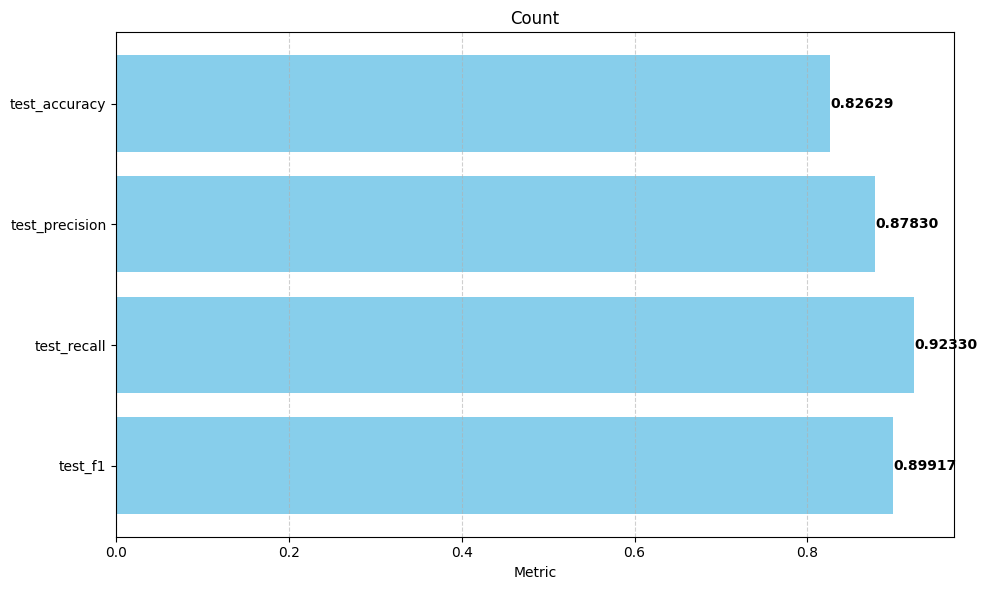

In [71]:
# from pprint import pprint
# pprint(trainer.predict(test_dataset=tokenized_datasets["test"]))
result = trainer.predict(test_dataset=tokenized_datasets["test"])
display_model_metric(result.metrics)

##### Checking Best Model on Unseen Set

100%|██████████| 12/12 [00:00<00:00, 15.82it/s]


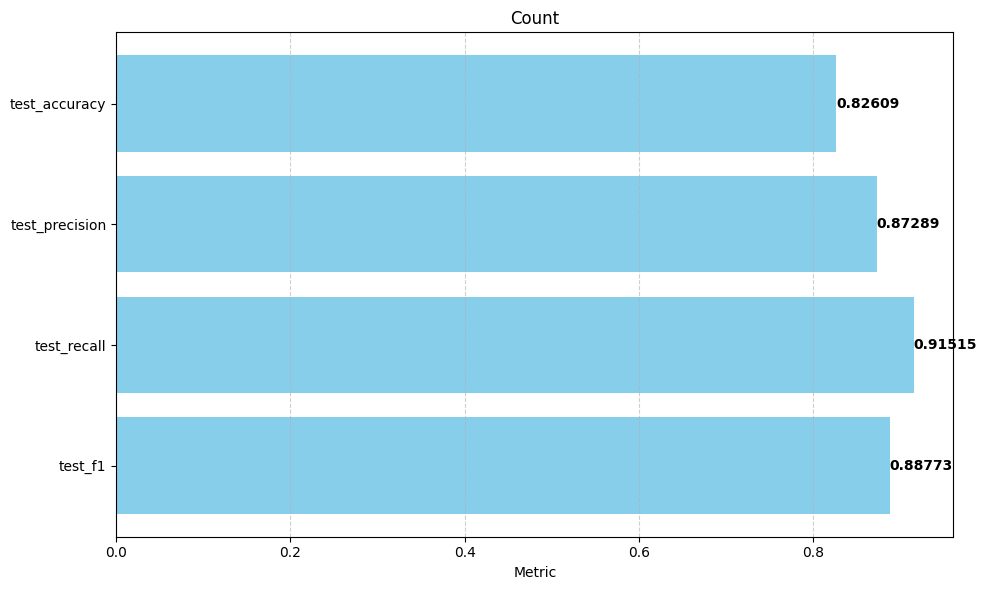

In [72]:
# from pprint import pprint
# pprint(trainer.predict(test_dataset=tokenized_datasets["test"]))
result = trainer.predict(test_dataset=tokenized_datasets["dev"])
display_model_metric(result.metrics)

## Saving the Best model i.e. Epoch 13 which has the highest F1 Score

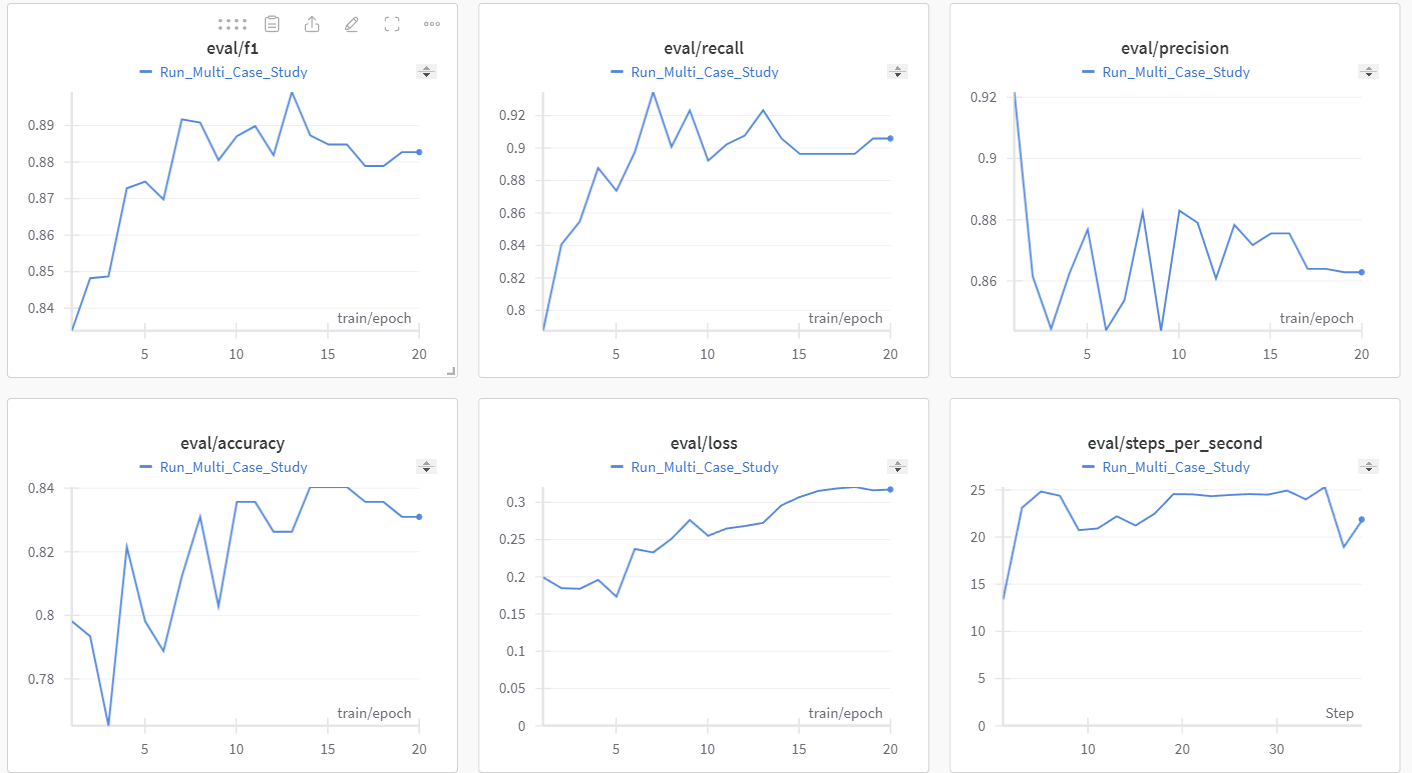

## Training Loss

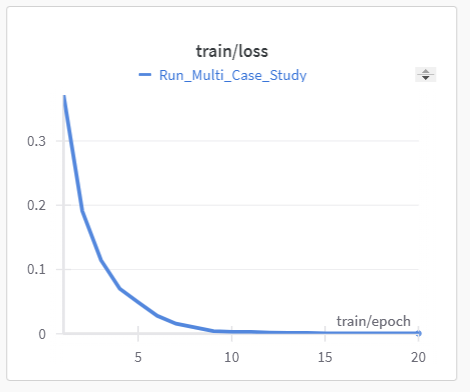
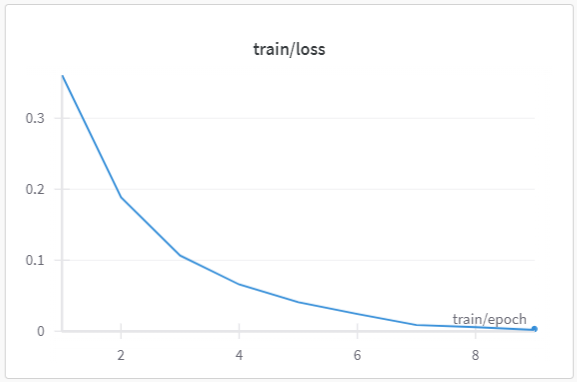

In [73]:

tokenizer.save_pretrained('artifacts/models/category/final')
trainer.save_model('artifacts/models/category/final')

### From the above Graph we can see that at Epoch 13 we got the Highest F1 Score. I selcted F1 Score as my Metric because I wanted the balance trade-off between the precision and recall.



## 3.3 Definition 2: Aspect term polarity i.e. Sentence Inferencing 

#### Here we will use Apect Term and Text to identify the Polarity.

creating folder important folders

In [59]:
create_directory(['artifacts/models/sentence_inference/term/epoch','artifacts/models/sentence_inference/term/final','artifacts/models/sentence_inference/category/epoch','artifacts/models/sentence_inference/category/final'])       

In [60]:
Process_NER_Dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'split_text', 'ner_label', 'term', 'polarity'],
        num_rows: 2736
    })
    test: Dataset({
        features: ['ID', 'text', 'split_text', 'ner_label', 'term', 'polarity'],
        num_rows: 213
    })
    dev: Dataset({
        features: ['ID', 'text', 'split_text', 'ner_label', 'term', 'polarity'],
        num_rows: 92
    })
})

##### Function for the Transforming dataset to be used as Sentence Inferencing

In [61]:
# sentence_term_data

def convert_sentence_term_polarity(examples):
    result={}
    result['ID']=[]
    result['text']=[]
    result['term']=[]
    result['polarity']=[]
    for id,text,term,polarity in zip(examples['ID'],examples['text'],examples['term'],examples['polarity']):
        for t,p in zip(term,polarity):
            result['ID'].append(id)
            result['text'].append(text)
            result['term'].append(t)
            result['polarity'].append(p)
    return result


In [62]:
Process_term_polarity_Dataset = Process_NER_Dataset.map(convert_sentence_term_polarity,batched=True,remove_columns=Process_NER_Dataset['train'].column_names)
Process_term_polarity_Dataset

Map: 100%|██████████| 92/92 [00:00<00:00, 35825.45 examples/s]


DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'term', 'polarity'],
        num_rows: 3297
    })
    test: Dataset({
        features: ['ID', 'text', 'term', 'polarity'],
        num_rows: 258
    })
    dev: Dataset({
        features: ['ID', 'text', 'term', 'polarity'],
        num_rows: 138
    })
})

In [63]:
Process_term_polarity_Dataset.set_format('pandas')
Process_term_polarity_Dataset['train'][10:12]

,ID,text,term,polarity
0,2642,"We a menu that rearely changes,e xcept for one...",quality,3
1,2642,"We a menu that rearely changes,e xcept for one...",care,3


In [64]:
Process_term_polarity_Dataset.reset_format()

##### Model, Tokenizer and Training Argument Loading 

In [65]:
from transformers import AutoTokenizer

from transformers import TrainingArguments
import os
from dotenv import load_dotenv

import wandb

from transformers import DataCollatorWithPadding

from transformers import AutoModelForSequenceClassification #, TrainingArguments, Trainer

load_dotenv()
wandb_key = os.getenv('WANDB_API_KEY')

wandb_key = os.getenv('WANDB_API_KEY')
wandb.login(key=wandb_key,relogin=True)

os.environ["WANDB_PROJECT"] = "New_Case_Study_Inferencing"
os.environ['WANDB_WATCH']= 'all'


polarity_id_label= {0:'conflict',1:'neutral',2:'negative',3:'positive'}
polarity_label_id=polarity_label

model_checkpoint = "dvquys/ner-finetune-restaurant-reviews-aspects" #"bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(
                                                            model_checkpoint, 
                                                            num_labels=len(polarity_id_label),
                                                            id2label=polarity_id_label, 
                                                            label2id=polarity_label_id,
                                                            ignore_mismatched_sizes=True
                                                        )

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

args = TrainingArguments(
                            output_dir="artifacts/models/sentence_inference/term/epoch",
                            logging_strategy = 'epoch',
                            # save_total_limit= 4,
                            eval_strategy="epoch",
                            save_strategy="epoch",
                            learning_rate=5e-5,
                            num_train_epochs=20,
                            weight_decay=0.01,
                            greater_is_better=True,
                            load_best_model_at_end=True,
                            metric_for_best_model='f1',
                            warmup_steps=500,
                            run_name = "Run_Term_Polarity_Case_Study_NLI",
                            report_to="wandb",
                        )

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/nabarunbarua/.netrc
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dvquys/ner-finetune-restaurant-reviews-aspects and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dvquys/ner-finetune-restaurant-reviews-aspects and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([21])

##### Tokenizing the Dataset

In [66]:
def tokenize_term_polarity(examples):
    tokenized_inputs = tokenizer(
                                    examples['text'],examples['term'], truncation=True 
                                )
    tokenized_inputs['labels'] = examples['polarity']
    return tokenized_inputs


tokenized_datasets = Process_term_polarity_Dataset.map(
                                                    tokenize_term_polarity,
                                                    batched=True,
                                                    remove_columns=Process_term_polarity_Dataset["train"].column_names,
                                                )

tokenized_datasets

Map: 100%|██████████| 138/138 [00:00<00:00, 27890.62 examples/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3297
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 258
    })
    dev: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 138
    })
})

##### Dataloader

In [67]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
                                tokenized_datasets["train"],
                                shuffle=True,
                                collate_fn=data_collator,
                                batch_size=8,
                            )
eval_dataloader = DataLoader(
                                tokenized_datasets["test"], 
                                collate_fn=data_collator, 
                                batch_size=8
                            )

##### This function helps during training for computing metric

In [68]:
import torch
import evaluate
import numpy as np
# from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
precision = evaluate.load('precision', average='macro')
recall = evaluate.load('recall', average='macro')
f1 = evaluate.load('f1', average='macro')
accuracy = evaluate.load('accuracy')

metric = evaluate.combine([ f1, precision, recall]) # 
 
def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    predictions = np.argmax(predictions, axis=1)
    result1 = metric.compute(predictions=predictions,references=labels,average='macro')
    result2 = accuracy.compute(predictions=predictions,references=labels)
    result = {'f1':result1['f1'],'recall':result1['recall'],'precision':result1['precision'],'accuracy':result2['accuracy']}
    return result

##### Starting Training

In [69]:
from transformers import Trainer
# from transformers import EarlyStoppingCallback

# erly_stp_clb = EarlyStoppingCallback(early_stopping_patience=3)
trainer = Trainer(
                    model=model,
                    args=args,
                    train_dataset=tokenized_datasets["train"],
                    eval_dataset=tokenized_datasets["test"],
                    data_collator=data_collator,
                    compute_metrics=compute_metrics,
                    tokenizer=tokenizer,
                    # callbacks=[erly_stp_clb],
                )
trainer.train()

wandb: Currently logged in as: nabarunbarua. Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  5%|▌         | 413/8260 [01:05<32:02,  4.08it/s]

{'loss': 0.8915, 'grad_norm': 10.790095329284668, 'learning_rate': 4.13e-05, 'epoch': 1.0}


/Users/nabarunbarua/miniconda3/envs/case_study/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                  
  5%|▌         | 413/8260 [01:07<32:02,  4.08it/s]

{'eval_loss': 0.8088329434394836, 'eval_f1': 0.4325724494932913, 'eval_recall': 0.45152043403684095, 'eval_precision': 0.5166523727844483, 'eval_accuracy': 0.6937984496124031, 'eval_runtime': 2.1529, 'eval_samples_per_second': 119.84, 'eval_steps_per_second': 15.328, 'epoch': 1.0}


 10%|█         | 826/8260 [02:06<24:04,  5.15it/s]  

{'loss': 0.6165, 'grad_norm': 6.3828325271606445, 'learning_rate': 4.789948453608248e-05, 'epoch': 2.0}


/Users/nabarunbarua/miniconda3/envs/case_study/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                  
 10%|█         | 826/8260 [02:07<24:04,  5.15it/s]

{'eval_loss': 0.7917327880859375, 'eval_f1': 0.49560976826560904, 'eval_recall': 0.5043844930022124, 'eval_precision': 0.574933882487703, 'eval_accuracy': 0.7403100775193798, 'eval_runtime': 1.5569, 'eval_samples_per_second': 165.713, 'eval_steps_per_second': 21.196, 'epoch': 2.0}


 15%|█▌        | 1239/8260 [03:06<22:09,  5.28it/s] 

{'loss': 0.4211, 'grad_norm': 1.2529200315475464, 'learning_rate': 4.5238402061855675e-05, 'epoch': 3.0}


                                                   
 15%|█▌        | 1239/8260 [03:08<22:09,  5.28it/s]

{'eval_loss': 0.8616998195648193, 'eval_f1': 0.5711177711177711, 'eval_recall': 0.5627750018644194, 'eval_precision': 0.595580201048951, 'eval_accuracy': 0.7131782945736435, 'eval_runtime': 1.5062, 'eval_samples_per_second': 171.295, 'eval_steps_per_second': 21.91, 'epoch': 3.0}


 20%|██        | 1652/8260 [04:07<23:32,  4.68it/s]  

{'loss': 0.2846, 'grad_norm': 16.812406539916992, 'learning_rate': 4.2577319587628865e-05, 'epoch': 4.0}


                                                   
 20%|██        | 1652/8260 [04:09<23:32,  4.68it/s]

{'eval_loss': 1.2675896883010864, 'eval_f1': 0.5044815977541047, 'eval_recall': 0.4935832898302136, 'eval_precision': 0.5225567491124355, 'eval_accuracy': 0.7170542635658915, 'eval_runtime': 1.4863, 'eval_samples_per_second': 173.588, 'eval_steps_per_second': 22.203, 'epoch': 4.0}


 25%|██▌       | 2065/8260 [05:15<23:40,  4.36it/s]  

{'loss': 0.2411, 'grad_norm': 113.92790222167969, 'learning_rate': 3.991623711340207e-05, 'epoch': 5.0}


                                                   
 25%|██▌       | 2065/8260 [05:17<23:40,  4.36it/s]

{'eval_loss': 1.1008127927780151, 'eval_f1': 0.5030553772198375, 'eval_recall': 0.5037940935192782, 'eval_precision': 0.5054355474247115, 'eval_accuracy': 0.7131782945736435, 'eval_runtime': 1.6351, 'eval_samples_per_second': 157.787, 'eval_steps_per_second': 20.182, 'epoch': 5.0}


 30%|███       | 2478/8260 [06:26<27:07,  3.55it/s]  

{'loss': 0.1804, 'grad_norm': 0.07834217697381973, 'learning_rate': 3.725515463917526e-05, 'epoch': 6.0}


                                                   
 30%|███       | 2478/8260 [06:28<27:07,  3.55it/s]

{'eval_loss': 1.4986571073532104, 'eval_f1': 0.4978439780937277, 'eval_recall': 0.487266015362816, 'eval_precision': 0.5156295639335731, 'eval_accuracy': 0.7054263565891473, 'eval_runtime': 1.843, 'eval_samples_per_second': 139.988, 'eval_steps_per_second': 17.905, 'epoch': 6.0}


 35%|███▌      | 2891/8260 [07:42<21:16,  4.21it/s]  

{'loss': 0.1407, 'grad_norm': 0.04796434938907623, 'learning_rate': 3.4594072164948457e-05, 'epoch': 7.0}


                                                   
 35%|███▌      | 2891/8260 [07:44<21:16,  4.21it/s]

{'eval_loss': 1.6099025011062622, 'eval_f1': 0.4932178147212196, 'eval_recall': 0.4786679344718721, 'eval_precision': 0.5374592919424309, 'eval_accuracy': 0.7131782945736435, 'eval_runtime': 1.5566, 'eval_samples_per_second': 165.749, 'eval_steps_per_second': 21.2, 'epoch': 7.0}


 40%|████      | 3304/8260 [08:53<11:23,  7.25it/s]  

{'loss': 0.0814, 'grad_norm': 0.024549130350351334, 'learning_rate': 3.193298969072165e-05, 'epoch': 8.0}


                                                   
 40%|████      | 3304/8260 [08:54<11:23,  7.25it/s]

{'eval_loss': 1.6869014501571655, 'eval_f1': 0.6230991230991231, 'eval_recall': 0.6316528699629602, 'eval_precision': 0.625562936957114, 'eval_accuracy': 0.7325581395348837, 'eval_runtime': 1.4861, 'eval_samples_per_second': 173.605, 'eval_steps_per_second': 22.205, 'epoch': 8.0}


 45%|████▌     | 3717/8260 [09:57<14:46,  5.12it/s]  

{'loss': 0.0813, 'grad_norm': 0.22633154690265656, 'learning_rate': 2.9271907216494848e-05, 'epoch': 9.0}


                                                   
 45%|████▌     | 3717/8260 [09:58<14:46,  5.12it/s]

{'eval_loss': 1.4790838956832886, 'eval_f1': 0.6433541538861933, 'eval_recall': 0.6592835657642877, 'eval_precision': 0.6308479532163742, 'eval_accuracy': 0.7441860465116279, 'eval_runtime': 1.7573, 'eval_samples_per_second': 146.818, 'eval_steps_per_second': 18.779, 'epoch': 9.0}


 50%|█████     | 4130/8260 [10:59<13:19,  5.16it/s]  

{'loss': 0.0683, 'grad_norm': 0.0036843381822109222, 'learning_rate': 2.661082474226804e-05, 'epoch': 10.0}


                                                   
 50%|█████     | 4130/8260 [11:00<13:19,  5.16it/s]

{'eval_loss': 1.7298444509506226, 'eval_f1': 0.6228036175710594, 'eval_recall': 0.6337922912471723, 'eval_precision': 0.6164525691699605, 'eval_accuracy': 0.7248062015503876, 'eval_runtime': 1.437, 'eval_samples_per_second': 179.54, 'eval_steps_per_second': 22.964, 'epoch': 10.0}


 55%|█████▌    | 4543/8260 [11:59<12:13,  5.07it/s]  

{'loss': 0.0524, 'grad_norm': 0.016086125746369362, 'learning_rate': 2.394974226804124e-05, 'epoch': 11.0}


                                                   
 55%|█████▌    | 4543/8260 [12:01<12:13,  5.07it/s]

{'eval_loss': 1.7985029220581055, 'eval_f1': 0.6419200653700411, 'eval_recall': 0.6516145872175405, 'eval_precision': 0.636197559707489, 'eval_accuracy': 0.748062015503876, 'eval_runtime': 1.4742, 'eval_samples_per_second': 175.004, 'eval_steps_per_second': 22.384, 'epoch': 11.0}


 60%|██████    | 4956/8260 [12:59<10:55,  5.04it/s]  

{'loss': 0.0354, 'grad_norm': 0.0036141483578830957, 'learning_rate': 2.1288659793814432e-05, 'epoch': 12.0}


                                                   
 60%|██████    | 4956/8260 [13:00<10:55,  5.04it/s]

{'eval_loss': 2.1215381622314453, 'eval_f1': 0.5128394639448894, 'eval_recall': 0.5086757650334353, 'eval_precision': 0.5200020567667627, 'eval_accuracy': 0.7209302325581395, 'eval_runtime': 1.4261, 'eval_samples_per_second': 180.911, 'eval_steps_per_second': 23.14, 'epoch': 12.0}


 65%|██████▌   | 5369/8260 [13:57<09:58,  4.83it/s]  

{'loss': 0.032, 'grad_norm': 0.03429155424237251, 'learning_rate': 1.862757731958763e-05, 'epoch': 13.0}


                                                   
 65%|██████▌   | 5369/8260 [13:59<09:58,  4.83it/s]

{'eval_loss': 1.9588851928710938, 'eval_f1': 0.5584997180137533, 'eval_recall': 0.5685531483829269, 'eval_precision': 0.5787356182277549, 'eval_accuracy': 0.7403100775193798, 'eval_runtime': 1.4201, 'eval_samples_per_second': 181.674, 'eval_steps_per_second': 23.237, 'epoch': 13.0}


 70%|███████   | 5782/8260 [14:56<08:09,  5.07it/s]  

{'loss': 0.0187, 'grad_norm': 0.0021795842330902815, 'learning_rate': 1.5966494845360824e-05, 'epoch': 14.0}


                                                   
 70%|███████   | 5782/8260 [14:57<08:09,  5.07it/s]

{'eval_loss': 1.9620217084884644, 'eval_f1': 0.5912376854476079, 'eval_recall': 0.5889498968354588, 'eval_precision': 0.5953243222376635, 'eval_accuracy': 0.7403100775193798, 'eval_runtime': 1.4348, 'eval_samples_per_second': 179.815, 'eval_steps_per_second': 23.0, 'epoch': 14.0}


 75%|███████▌  | 6195/8260 [15:54<04:09,  8.26it/s]

{'loss': 0.024, 'grad_norm': 0.053470298647880554, 'learning_rate': 1.330541237113402e-05, 'epoch': 15.0}


                                                   
 75%|███████▌  | 6195/8260 [15:55<04:09,  8.26it/s]

{'eval_loss': 1.9647363424301147, 'eval_f1': 0.5890228579470065, 'eval_recall': 0.5717055708852263, 'eval_precision': 0.6236527446799616, 'eval_accuracy': 0.748062015503876, 'eval_runtime': 1.3889, 'eval_samples_per_second': 185.752, 'eval_steps_per_second': 23.759, 'epoch': 15.0}


 80%|████████  | 6608/8260 [16:52<05:12,  5.29it/s]

{'loss': 0.0198, 'grad_norm': 0.0015975504647940397, 'learning_rate': 1.0644329896907216e-05, 'epoch': 16.0}


                                                   
 80%|████████  | 6608/8260 [16:53<05:12,  5.29it/s]

{'eval_loss': 1.9517687559127808, 'eval_f1': 0.5762463402732596, 'eval_recall': 0.5850330623710444, 'eval_precision': 0.5755231101008336, 'eval_accuracy': 0.7403100775193798, 'eval_runtime': 1.4182, 'eval_samples_per_second': 181.917, 'eval_steps_per_second': 23.268, 'epoch': 16.0}


 85%|████████▌ | 7021/8260 [17:50<03:56,  5.24it/s]

{'loss': 0.0131, 'grad_norm': 0.0017940287943929434, 'learning_rate': 7.983247422680412e-06, 'epoch': 17.0}


                                                   
 85%|████████▌ | 7021/8260 [17:51<03:56,  5.24it/s]

{'eval_loss': 2.1065330505371094, 'eval_f1': 0.5642091906258253, 'eval_recall': 0.5689400154125338, 'eval_precision': 0.5610111208662569, 'eval_accuracy': 0.7170542635658915, 'eval_runtime': 1.4224, 'eval_samples_per_second': 181.389, 'eval_steps_per_second': 23.201, 'epoch': 17.0}


 90%|█████████ | 7434/8260 [18:47<01:38,  8.38it/s]

{'loss': 0.0118, 'grad_norm': 0.002438827184960246, 'learning_rate': 5.322164948453608e-06, 'epoch': 18.0}


                                                   
 90%|█████████ | 7434/8260 [18:49<01:38,  8.38it/s]

{'eval_loss': 2.180246114730835, 'eval_f1': 0.5594493304580095, 'eval_recall': 0.5680109130683372, 'eval_precision': 0.5555477746654217, 'eval_accuracy': 0.7209302325581395, 'eval_runtime': 1.7329, 'eval_samples_per_second': 148.88, 'eval_steps_per_second': 19.043, 'epoch': 18.0}


 95%|█████████▌| 7847/8260 [19:45<00:52,  7.85it/s]

{'loss': 0.0078, 'grad_norm': 0.0012062921887263656, 'learning_rate': 2.661082474226804e-06, 'epoch': 19.0}


                                                   
 95%|█████████▌| 7847/8260 [19:47<00:52,  7.85it/s]

{'eval_loss': 2.168628454208374, 'eval_f1': 0.5663535304556802, 'eval_recall': 0.5735280408680737, 'eval_precision': 0.5649132550513065, 'eval_accuracy': 0.7286821705426356, 'eval_runtime': 1.4023, 'eval_samples_per_second': 183.978, 'eval_steps_per_second': 23.532, 'epoch': 19.0}


100%|██████████| 8260/8260 [20:46<00:00,  5.35it/s]

{'loss': 0.0064, 'grad_norm': 0.006785500794649124, 'learning_rate': 0.0, 'epoch': 20.0}


                                                   
100%|██████████| 8260/8260 [20:47<00:00,  5.35it/s]

{'eval_loss': 2.1537578105926514, 'eval_f1': 0.5733803953832505, 'eval_recall': 0.5754219802620131, 'eval_precision': 0.5744496218881672, 'eval_accuracy': 0.7325581395348837, 'eval_runtime': 1.5178, 'eval_samples_per_second': 169.985, 'eval_steps_per_second': 21.742, 'epoch': 20.0}


100%|██████████| 8260/8260 [20:50<00:00,  6.61it/s]

{'train_runtime': 1251.5828, 'train_samples_per_second': 52.685, 'train_steps_per_second': 6.6, 'train_loss': 0.16141690512257684, 'epoch': 20.0}


TrainOutput(global_step=8260, training_loss=0.16141690512257684, metrics={'train_runtime': 1251.5828, 'train_samples_per_second': 52.685, 'train_steps_per_second': 6.6, 'total_flos': 1646677220258304.0, 'train_loss': 0.16141690512257684, 'epoch': 20.0})

##### Checking Best Model on Test Set i.e Epoch 9

100%|██████████| 33/33 [00:01<00:00, 22.04it/s]


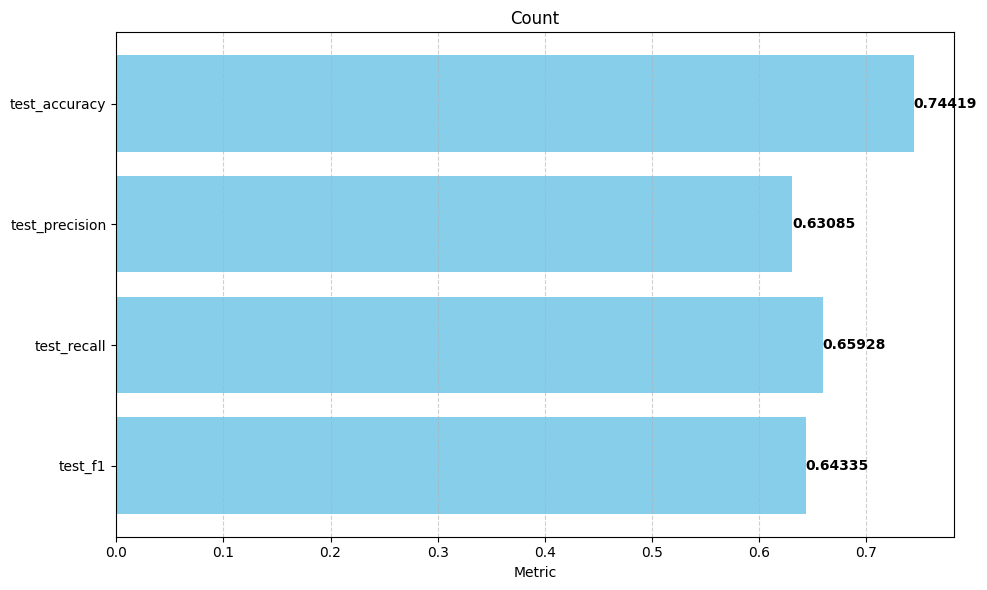

In [70]:
# from pprint import pprint
# pprint(trainer.predict(test_dataset=tokenized_datasets["test"]))

result = trainer.predict(test_dataset=tokenized_datasets["test"])
display_model_metric(result.metrics)

##### Checking Best Model on Unseen Set

100%|██████████| 18/18 [00:00<00:00, 19.78it/s]


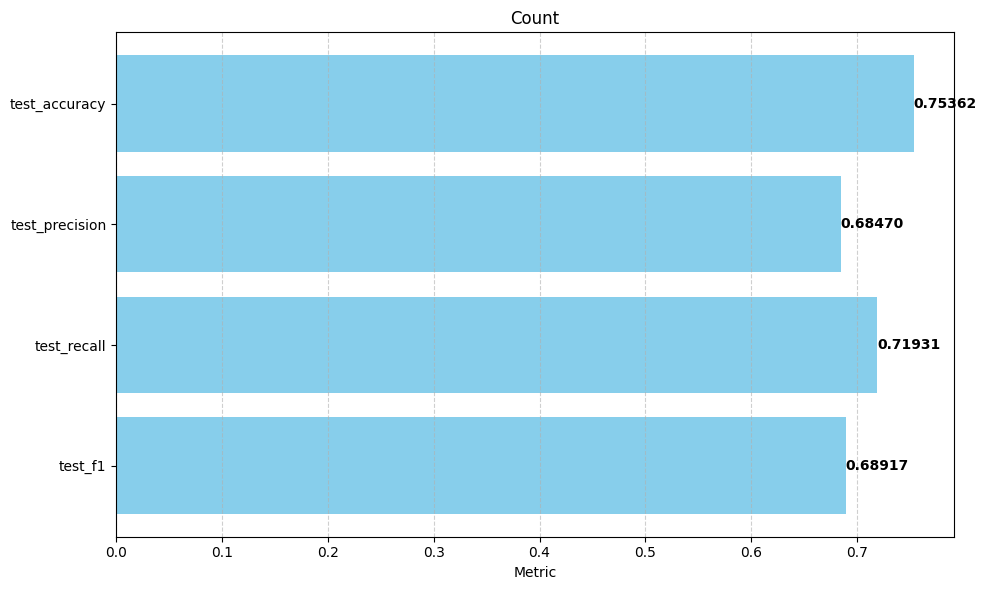

In [71]:
result = trainer.predict(test_dataset=tokenized_datasets["dev"])
display_model_metric(result.metrics)

## Here we got Best F1 at epoch 9 i.e. 0.64335 F1 Score. We will save the Best Model. Though on Unseen set we got slightly higher value of 0.68917. This is not a very good score so we will try using LLM. We will be using OLLAMA for LLM as it host most opensource LLM and it is free just need to install on PC to be used.

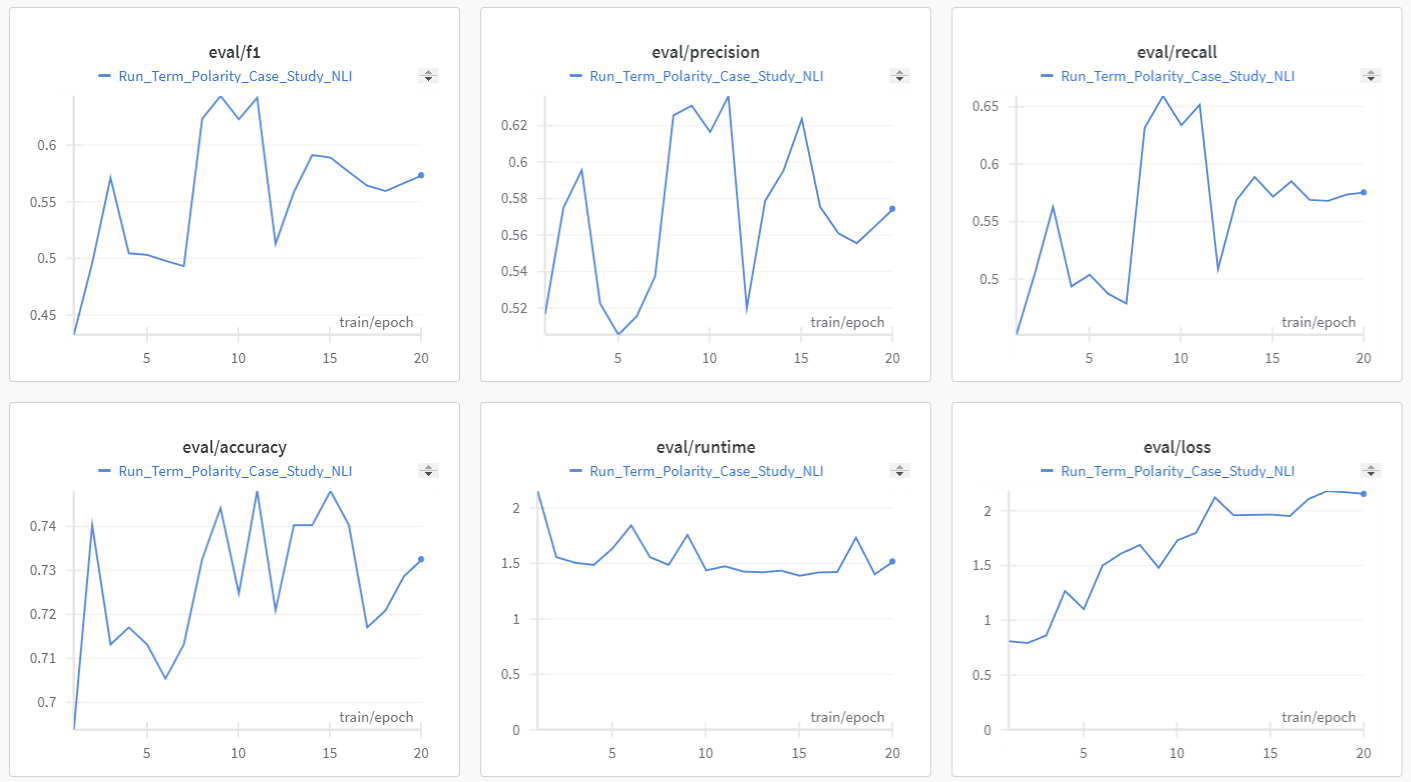

## Training Loss

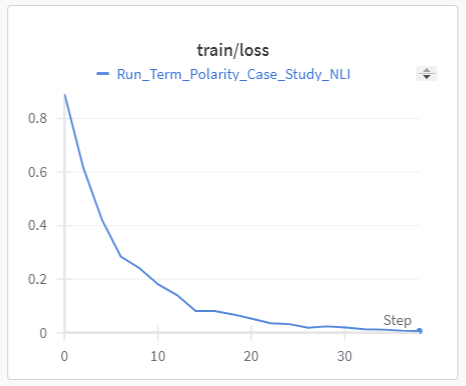

In [72]:

tokenizer.save_pretrained('artifacts/models/sentence_inference/term/final')
trainer.save_model('artifacts/models/sentence_inference/term/final')

## We are now Testing with the LLM to check if we can get better result on sentiment analysis

### We are using OLLAMA as it provide multiple opensource LLM on PC. We are using mixtral 8x7b model.

Installation steps: Please execute below commands

- Download and Install OLLAMA
```bash
curl -fsSL https://ollama.com/install.sh | sh
```
- Pull Mixtral Model
```bash
ollama pull mixtral 
```


In [73]:
import requests
import json
def LLM(text):
    url = "http://localhost:11434/api/generate"
    headers = {
                'Content-Type': 'application/json',
            }
    data = {
            "model": "mixtral",
            "stream": False,
            "system": """<s>[INST]You are an intelligent AI Bot for a restaurant tasked with determining the sentiment polarity of an extracted term from a user review. Based on the provided User Review and Term, your task is to output only the sentiment polarity: positive, negative, neutral, or conflict.

Do not provide any explanations or additional information or generate other examples. Only output one of the following values: positive, negative, neutral, or conflict.
	- User Review: This is the user's opinion about the restaurant, its food, service, or other aspects that influence the overall experience. It will be provided.
	- Term: This is the entity or aspect extracted from the User Review. You will be given the specific term that the review is about.
	- Polarity: Your task is to analyze both the User Review and the Term to assign a sentiment polarity. The polarity will be one of the following: positive, negative, neutral, or conflict.

Example Analysis:
You will be provided with four examples to clarify how sentiment polarity works.
	1. Negative Polarity Example
		- User Review: "But the staff was so horrible to us."
		- Term: staff
		- Polarity: negative

	2. Positive Polarity Example
		- User Review: "To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora."
		- Term: food
		- Polarity: positive

	3. Neutral Polarity Example
		- User Review: "The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not."
		- Term: menu
		- Polarity: neutral

	4. Conflict Polarity Example
		- User Review: "The food was delicious but do not come here on an empty stomach."
		- Term: food
		- Polarity: conflict 

Your Task: Based on the User Review and the provided Term, determine the correct sentiment Polarity(provide only the Polarity without explanation & etc) using the reasoning process as shown in the examples. Your output should only provide the final polarity value in this format:

User Review: [Review will be provided]
Term: [Term will be provided]
Polarity: [Output only the polarity: positive, negative, neutral, or conflict]
[/INST]""",
            "max_tokens": 10,
            "temperature": 0.3,
            "top_p": 0.3,
            "prompt": text,
        }

    response = requests.post(url, headers=headers, data=json.dumps(data))

    if response.status_code == 200:
        response_text = response.text
        data = json.loads(response_text)
        llm_response = data["response"]
        return llm_response
    else:
        print("Error:", response.status_code, response.text)
        return None

In [74]:
template = """User Review: {review}
Term: {term}
Polarity:"""

text = template.format(review="The service varys from day to day- sometimes they're very nice, and sometimes not.",
                       term="service")

In [75]:
output= LLM(text)

output.strip()

'conflict'

##### Tried Multiple examples, COT Prompt working well with Mixtral LLM. Now preparing a function so that we can bench mark it

In [78]:
import evaluate
precision = evaluate.load('precision', average='macro')
recall = evaluate.load('recall', average='macro')
f1 = evaluate.load('f1', average='macro')
accuracy = evaluate.load('accuracy')

metric = evaluate.combine([ f1, precision, recall])



In [79]:
from tqdm.auto import tqdm
# ground_truth=[]
# prediction=[]
def llm_benchmark(data_set):
    template = """User Review: {review}
Term: {term}
Polarity:"""
    ground_truth=[]
    prediction=[]
    # t =0 
    ProgressBar = tqdm(range(len(data_set)))
    for item in data_set:
        text = template.format(
                                review=item['text'],
                                term=item['term']
                            )
        output= LLM(text)
        output=output.strip()
        pred = output[:8] if len(output)>8 else output 
        pred = pred.lower().replace('\n',"").strip()
        if pred not in list(polarity_label.keys()):
            ProgressBar.update(1)
            continue
        pred = polarity_label[pred]
        prediction.append(pred)
        ground_truth.append(item['polarity'])
        ProgressBar.update(1)
        # if t<10:
        #     t +=1
        # else:
        #     break
    result1 = metric.compute(predictions=prediction,references=ground_truth,average='macro')
    result2 = accuracy.compute(predictions=prediction,references=ground_truth)
    result = {'f1':result1['f1'],'recall':result1['recall'],'precision':result1['precision'],'accuracy':result2['accuracy']}
    display_model_metric(result)
    return result

##### LLM Mixtral's result on Unseen dataset

100%|██████████| 138/138 [40:16<00:00, 17.10s/it] /Users/nabarunbarua/miniconda3/envs/case_study/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 138/138 [40:18<00:00, 17.52s/it]


{'f1': 0.4815905743740795,
 'recall': 0.48873401035055175,
 'precision': 0.4758206251351936,
 'accuracy': 0.7318840579710145}

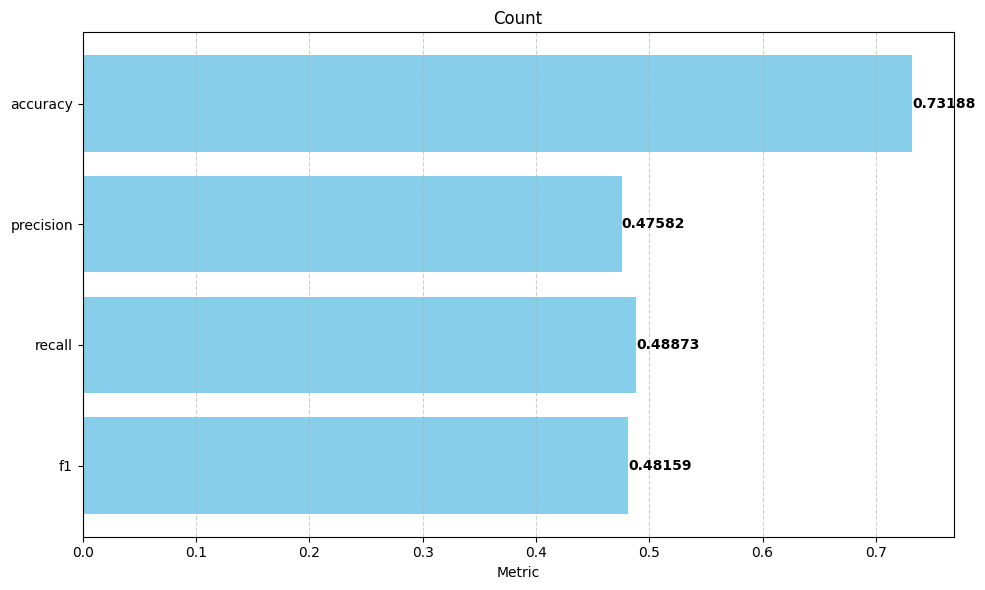

In [80]:
Process_term_polarity_Dataset.reset_format()
result = llm_benchmark(Process_term_polarity_Dataset['dev'])
result

## Results are not as Expected worst then the model trained. Need more investigation. Following are my thought process

- Positive class was the highest among all other class
- Since dataset is imbalance, we have selected Macro because of which F1, Recall and Precision score went down but Accuracy was high
- To mitigate it we can do with of thing
    - If we can add more samples in other classes or do some sampling technique
    - or implement different loss by overriding standard loss function add weigtage to the class so that model learn more to predict other classes correctly

### Comparing Both Sentence Inferencing Model and LLM Results


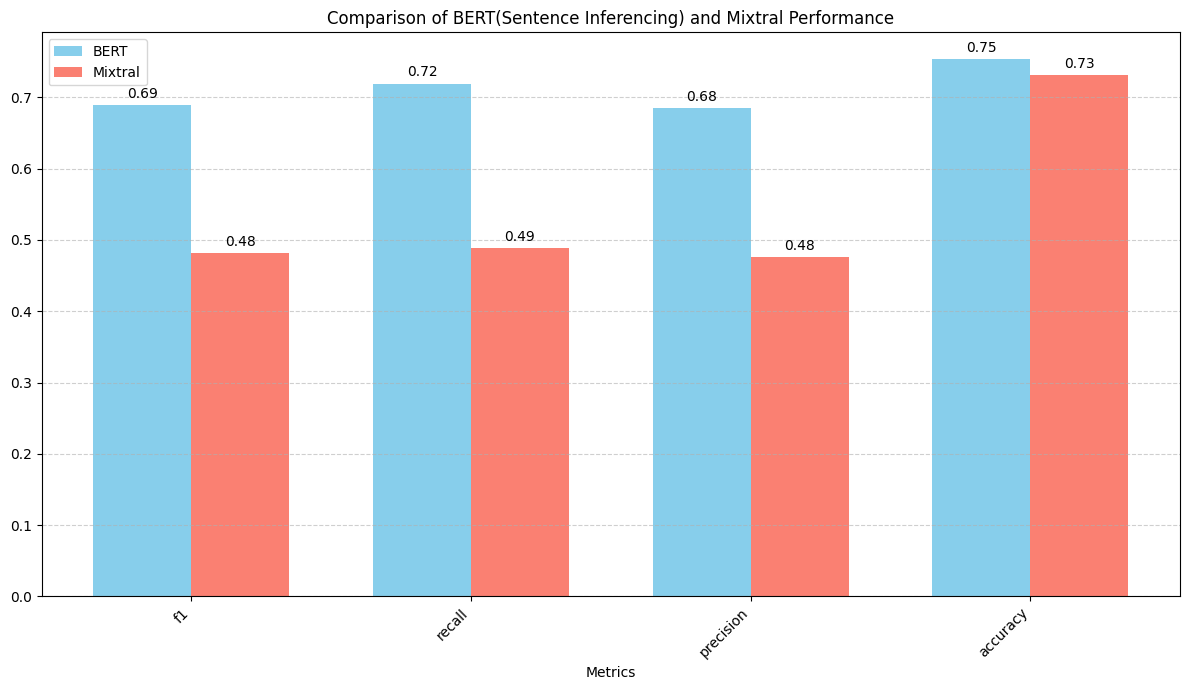

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from two models
metrics_model1 = {
                    'f1': 0.68917, 
                    'recall': 0.71931, 
                    'precision': 0.68470, 
                    'accuracy': 0.75362, 
                }

metrics_model2 = {'f1': 0.4815905743740795,
                'recall': 0.48873401035055175,
                'precision': 0.4758206251351936,
                'accuracy': 0.7318840579710145}

# Extracting metric names and values
metric_names = list(metrics_model1.keys())
model1_values = list(metrics_model1.values())
model2_values = list(metrics_model2.values())

# Defining the position of the bars
x = np.arange(len(metric_names))  # the label locations
width = 0.35  # the width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))
bars_model1 = ax.bar(x - width/2, model1_values, width, label='BERT', color='skyblue')
bars_model2 = ax.bar(x + width/2, model2_values, width, label='Mixtral', color='salmon')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_title('Comparison of BERT(Sentence Inferencing) and Mixtral Performance')
ax.set_xticks(x)
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend()

# Displaying the values on the bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars_model1)
add_value_labels(bars_model2)

# Adjust layout and show the plot
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()


# End of Case Study

In [ ]:
from tqdm.auto import tqdm
# ground_truth=[]
# prediction=[]
def llm_benchmark_(data_set):
    template = """User Review: {review}
Term: {term}
Polarity:"""
    ground_truth=[]
    prediction=[]
    # t =0 
    ProgressBar = tqdm(range(len(data_set)))
    for item in data_set:
        text = template.format(
                                review=item['text'],
                                term=item['term']
                            )
        output= LLM(text)
        output=output.strip()
        pred = output[:8] if len(output)>8 else output 
        pred = pred.lower().replace('\n',"").strip()
        if pred not in list(polarity_label.keys()):
            ProgressBar.update(1)
            continue
        pred = polarity_label[pred]
        prediction.append(pred)
        ground_truth.append(item['polarity'])
        ProgressBar.update(1)
        # if t<10:
        #     t +=1
        # else:
        #     break
    result1 = metric.compute(predictions=prediction,references=ground_truth,average='macro')
    result2 = accuracy.compute(predictions=prediction,references=ground_truth)
    result = {'f1':result1['f1'],'recall':result1['recall'],'precision':result1['precision'],'accuracy':result2['accuracy']}
    return result

In [65]:
# # 'ID', 'text', 'term', 'polarity'
# Process_term_polarity_Dataset.reset_format()
# Process_term_polarity_Dataset['test'][1]

{'ID': '16',
 'text': 'night without a reservation, we had to wait at the bar for a little while, but the manager was so nice and made our wait a great experience.',
 'term': 'manager',
 'polarity': 3}

In [71]:
list(polarity_label.keys())

['conflict', 'neutral', 'negative', 'positive']

In [121]:
for i in Process_term_polarity_Dataset['test']:
    print(i)
    break

{'ID': '418', 'text': 'The food arrived 20 minutes after I called, cold and soggy.', 'term': 'food', 'polarity': 2}


In [ ]:
# from sentence_transformers import CrossEncoder
# model = CrossEncoder("cross-encoder/nli-deberta-v3-base")

# scores = model.predict([
#     ("The rest of the menu is limited by everything is good eats.", "Slightly on the pricey side but worth it!"),
#     ("food", "price"),
# ])

# # Convert scores to labels
# label_mapping = ["contradiction", "entailment", "neutral"]
# labels = [label_mapping[score_max] for score_max in scores.argmax(axis=1)]
# labels

In [ ]:
# # flat_dataset['train'][:1]

# NER Dataset NER Label and SPlit NER TEXT
# Then for EDA dataset example Term and polarity

In [ ]:

# from transformers import get_scheduler

# num_train_epochs = 10
# num_update_steps_per_epoch = len(train_dataloader)
# num_training_steps = num_train_epochs * num_update_steps_per_epoch

# lr_scheduler = get_scheduler(
#                                 "linear",
#                                 optimizer=optimizer,
#                                 num_warmup_steps=500,
#                                 num_training_steps=num_training_steps,
#                             )

# def postprocess(predictions, labels):
#     predictions = predictions.detach().cpu().clone().numpy()
#     labels = labels.detach().cpu().clone().numpy()

#     # Remove ignored index (special tokens) and convert to labels
#     true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
#     true_predictions = [
#         [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
#         for prediction, label in zip(predictions, labels)
#     ]
#     return true_labels, true_predictions



##### Training Loop

In [ ]:
# from tqdm.auto import tqdm
# import torch

# progress_bar = tqdm(range(num_training_steps))

# for epoch in range(num_train_epochs):
#     # Training
#     model.train()
#     for batch in train_dataloader:
#         batch1 = {k:v.to("mps") for k,v in batch.items()}
#         outputs = model(**batch1)
#         loss = outputs.loss
#         loss.backward()

#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         progress_bar.update(1)

#     # Evaluation
#     model.eval()
#     for batch in eval_dataloader:
#         with torch.no_grad():
#             outputs = model(**batch)

#         predictions = outputs.logits.argmax(dim=-1)
#         labels = batch["labels"]

#         # Necessary to pad predictions and labels for being gathered
#         predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
#         labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

#         predictions_gathered = accelerator.gather(predictions)
#         labels_gathered = accelerator.gather(labels)

#         true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
#         metric.add_batch(predictions=true_predictions, references=true_labels)

#     results = metric.compute()
#     print(
#         f"epoch {epoch}:",
#         {
#             key: results[f"overall_{key}"]
#             for key in ["precision", "recall", "f1", "accuracy"]
#         },
#     )

     

In [155]:
# polarity_label = {'neutral':0,'negative':1,'positive':2}
# test = []
# test1 = ['neutral','neutral']
# tmp = [polarity_label[i] for i in test1]
# test.extend(tmp)
# test

[0, 0]

In [46]:
# text = """Don't go alone---even two people isn't 'enough' for the whole experience, with pickles and a selection of meats and seafoods."""
# from nltk.tokenize import TweetTokenizer
# tokenizer = TweetTokenizer()

# tokenizer.tokenize(text)


In [47]:
# text = "Don't go alone---even two people isn't enough for the whole experience, with pickles and a selection of meats and seafoods."
# term="selection of meats and seafoods"
# from_to =(91,122)

# split_text = text.split()
# ner_label = [0]*len(split_text)
# # print(split_text)
# def get_ner(split_text,term,from_to,ner_label):
#   # split_text = text.split()
#   split_term = term.split()

#   next=0
#   last=0
#   word_range=[]
#   index_range=[]
#   for k,v in enumerate(split_text):
#     word_range.append(v)
#     index_range.append(next)
#     if k == 0:
#       last = len(v)+1
#     else:
#       last=last+len(v)+1
#     next = last
#   t_index = index_range.index(from_to[0])
#   end = t_index + len(split_term)
#   for k,v in enumerate(range(t_index,end)):
#     if k==0:
#       ner_label[v]= 1
#     else:
#       ner_label[v]= 2
#   # print(ner_label)
#   return word_range, ner_label
#   # print(split_text)
# word_range, ner_label=get_ner(split_text,term,from_to,ner_label)

# word_range, ner_label